# Lifelines Datathon
Team TM-207

Members = Alyssa @ijcol, Nigel @nigelyeap, Louis @auminove
### Background
CTG is a monitoring technique during pregnancy and labor that records fetal heart 
rate (FHR) and uterine contractions (UC) to assess fetal well-being. The fetus can experience hypoxia (lack of oxygen). CTG aims to detect early 
warning signs so doctors can intervene before serious harm (brain damage, 
stillbirth).

### Objective
Determining CTG probabilities of a patient, such that doctors are able to acess risk levels more accurately. Develop a predictive model that has the ability to estimate the probability of fetal outcomes in Normal/Suspecting/Pathological from CTG data.

## Sections of this notebook
----
#### 1. Literature
- Explanations
- Summary
#### 2. Exploratory Data Analysis (EDA)
- Data cleaning and exploration
- Insights
- Feature selection
#### 3. ML Model Pipeline
- Preprocessing
- Training & Evaluation
- Feature Importances
- Optimization (hyperparam tuning)
- Comparisons & Predictions

## 1. Literature


Project Goals
- Exploratory Data Analysis (EDA) would be carried out to explore, understand and gain insights to the datasets and the nature of NSP and the contributing attributes and underlying relationships between each feature to better understand the medical context of CTGs
- With insights and better understanding, an end-to-end Machine Learning pipeline can be designed, and deployed to ingest data that has been cleaned, transformed and engineered towards receiving quality results in prediction and accuracy. Two machine learning algorithms will be deployed to predict. With the use of two algorithms, comparisons can be made between the two, in terms of accuracy, and other determining metrics.

#### Executive Summary of model pipeline

Target column = NSP

Based on the description of the dataset, there are three statuses of fetal well-being -> normal N, suspect S, and pathological P

- NSP used as the target of the model, as the objective is to predict the probability of fetal outcomes
- Dataset comprises of fully numerical features; skipping a step in OHE for categorical variables reduces preprocessing steps and saves computation time.
- Chose not to bin and vectorize data as it would increase dimensionality and complexity
- NSP consists categorical values 1, 2, and 3; which requires adjustment (shifting to 0, 1, 2 by -1) for compatibility with models that expect zero-based class labels, such as XGBoost
- Multi-class classification problem -> utilization of ensemble methods such as Random Forest, Extra Trees, XGBoost
- Ensemble classifier's metric of performance is ROC and AUC to show the performance over curve rather than traditionally looking at train/test performance

Chose RF and XGBoost for their robustness - especially given that this is for a medical use-case

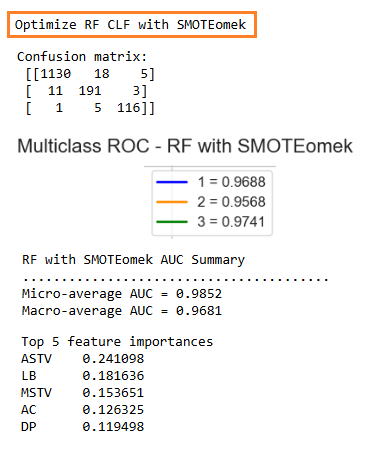

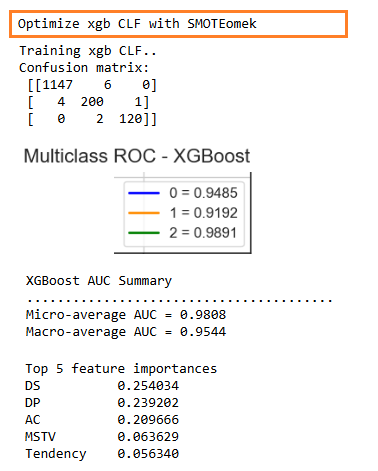

Overall,
-  Both models perform exceptionally well with AUC scores >0.95, indicating strong discriminative ability across all three classes

##### Prediction

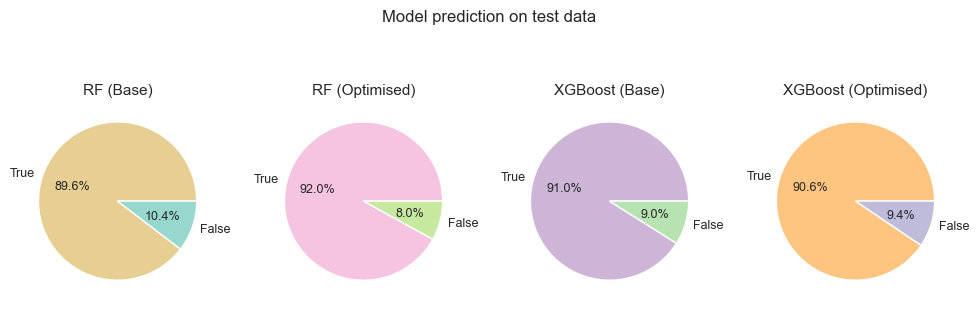
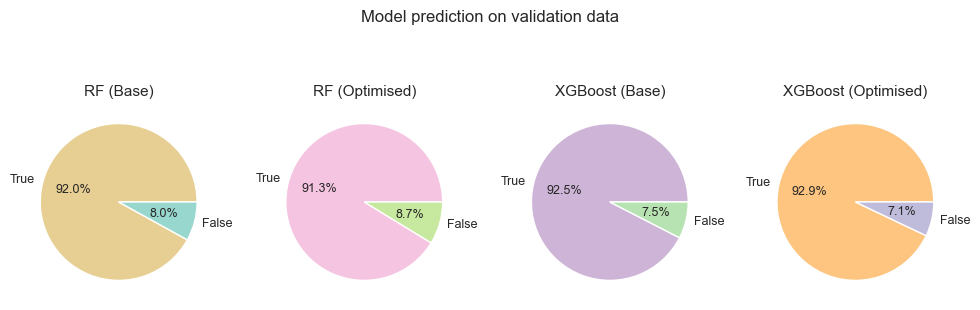

- Validation data shows slightly better performance (92-92.9% accuracy) compared to test data (89.6-92% accuracy), suggesting that the models generalize reasonably well to unseen data
- XGB + SMOTE optimization made test performance worse, going from (91.0% base test accuracy to 90.6% optimised test accuracy); indication of overfitting to validation data -> where optimization may not always help
- XGB + SMOTE (90.6% test accuracy to 92.9% val accuracy)
- RF + SMOTE optimization successfully improved test performance while maintaining strong validation results

Overall, RF + SMOTE has high test accuracy (92%) and a small validation-test gap (0.7%), it indicates the model generalizes well with the lowest risk of overfitting-> reliable in performance on unseen data going forward

## 2. Exploratory Data Analysis (EDA) 
### Objective
Identify patterns that distinguish normal, suspect, and pathologic fetuses
- Explore given data
- Examine correlations between key CTG features
- Identify features that are most indicative
- Provide insights to guide the prioritization of features for subsequent model training

#### 1. Initial analysis on Dataset

In [53]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy import stats
import seaborn.objects as so

# Import pyexcel to convert .xls file format to .xlsx
# for compatibility with pandas
import pyexcel as p
p.save_book_as(file_name="CTG.xls", dest_file_name="CTG.xlsx")

df = pd.read_excel("CTG.xlsx", sheet_name="Data")
print(f"first five rows of dataset =\n",df.head())
print(f"\nshape of data = ",df.shape)

first five rows of dataset =
   Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0          b          e         AC         FM         UC         DL   
1        240        357          0          0          0          0   
2          5        632          4          0          4          2   
3        177        779          2          0          5          2   
4        411       1192          2          0          6          2   

  Unnamed: 6 Unnamed: 7 Unnamed: 8  Unnamed: 9  ... Unnamed: 36 Unnamed: 37  \
0         DS         DP         DR         NaN  ...           E          AD   
1          0          0          0         NaN  ...          -1          -1   
2          0          0          0         NaN  ...          -1           1   
3          0          0          0         NaN  ...          -1           1   
4          0          0          0         NaN  ...          -1           1   

  Unnamed: 38 Unnamed: 39 Unnamed: 40 Unnamed: 41 Unnamed: 42     22

In [54]:
# The initial headers of the .xlsx file are not meaningful
df1 = df.copy()
# Drop headers, and set the leading row as headers of the dataframe
df1.columns = df1.iloc[0]
df1 = df1.drop(index=0)
df1 = df1.reset_index(drop=True)
df1

,b,e,AC,FM,UC,DL,DS,DP,DR,NaN,...,E,AD,DE,LD,FS,SUSP,NaN,CLASS,NaN,NSP
0,240,357,0,0,0,0,0,0,0,NaN,...,-1,-1,-1,-1,1,-1,NaN,9,NaN,2
1,5,632,4,0,4,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
2,177,779,2,0,5,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
3,411,1192,2,0,6,2,0,0,0,NaN,...,-1,1,-1,-1,-1,-1,NaN,6,NaN,1
4,533,1147,4,0,5,0,0,0,0,NaN,...,-1,-1,-1,-1,-1,-1,NaN,2,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1576,3049,1,0,9,0,0,0,0,NaN,...,1,-1,-1,-1,-1,-1,NaN,5,NaN,2
2125,2796,3415,1,1,5,0,0,0,0,NaN,...,-1,-1,-1,-1,-1,-1,NaN,1,NaN,1
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,...,72,332,252,107,69,197,NaN,NaN,NaN,NaN


In [55]:
# Look into all the columns present in dataset
print(f"columns =\n",df1.columns)
print(f"\nremove all columns that are NaN, \
as they are separators and do not provide any meaningful insights\n\
\ncolumns after dropping NaN cols =\n",(df1 := df1.loc[:, df1.columns.notna()]).columns)

columns =
 Index([       'b',        'e',       'AC',       'FM',       'UC',       'DL',
             'DS',       'DP',       'DR',        nan,       'LB',       'AC',
             'FM',       'UC',       'DL',       'DS',       'DP',     'ASTV',
           'MSTV',     'ALTV',     'MLTV',    'Width',      'Min',      'Max',
           'Nmax',   'Nzeros',     'Mode',     'Mean',   'Median', 'Variance',
       'Tendency',        nan,        'A',        'B',        'C',        'D',
              'E',       'AD',       'DE',       'LD',       'FS',     'SUSP',
              nan,    'CLASS',        nan,      'NSP'],
      dtype='object', name=0)

remove all columns that are NaN, as they are separators and do not provide any meaningful insights

columns after dropping NaN cols =
 Index(['b', 'e', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR', 'LB', 'AC', 'FM',
       'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min',
       'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 

In [56]:
for i in df1.columns:
    if isinstance(df1[i], pd.Series):
        print(f"Column '{i}' = {df1[i].dtype}")
    else:
        print(f"Column '{i}' = {type(df1[i])}")

Column 'b' = object
Column 'e' = object
Column 'AC' = <class 'pandas.core.frame.DataFrame'>
Column 'FM' = <class 'pandas.core.frame.DataFrame'>
Column 'UC' = <class 'pandas.core.frame.DataFrame'>
Column 'DL' = <class 'pandas.core.frame.DataFrame'>
Column 'DS' = <class 'pandas.core.frame.DataFrame'>
Column 'DP' = <class 'pandas.core.frame.DataFrame'>
Column 'DR' = object
Column 'LB' = object
Column 'AC' = <class 'pandas.core.frame.DataFrame'>
Column 'FM' = <class 'pandas.core.frame.DataFrame'>
Column 'UC' = <class 'pandas.core.frame.DataFrame'>
Column 'DL' = <class 'pandas.core.frame.DataFrame'>
Column 'DS' = <class 'pandas.core.frame.DataFrame'>
Column 'DP' = <class 'pandas.core.frame.DataFrame'>
Column 'ASTV' = object
Column 'MSTV' = object
Column 'ALTV' = object
Column 'MLTV' = object
Column 'Width' = object
Column 'Min' = object
Column 'Max' = object
Column 'Nmax' = object
Column 'Nzeros' = object
Column 'Mode' = object
Column 'Mean' = object
Column 'Median' = object
Column 'Varianc

All the columns should have dtypes, but columns that have the type = <class 'pandas.core.frame.DataFrame'> could be due to duplicated col names

In [57]:
# Check the validity of assumption
duplicates = df1.columns[df1.columns.duplicated()]
print("Duplicated column names = ", duplicates.tolist())

Duplicated column names =  ['AC', 'FM', 'UC', 'DL', 'DS', 'DP']


In [58]:
# Fix the duplicated col names by appending "_2" on the second occurrence
def rename(col):
    seen = {} ; new = []
    for i in col.astype(str):
        if i in seen:
            seen[i] += 1
            new.append(f"{i}_{seen[i]}")
        else:
            seen[i] = 1
            new.append(i)
    return new

df1.columns = rename(pd.Series(df1.columns))
print(f"After appending =\n",df1.columns)

After appending =
 Index(['b', 'e', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR', 'LB', 'AC_2',
       'FM_2', 'UC_2', 'DL_2', 'DS_2', 'DP_2', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
       'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS',
       'SUSP', 'CLASS', 'NSP'],
      dtype='object')


In [59]:
# Change all dtypes to float64 for easier parsing and visualization
df1 = df1.astype('float64')

# Check for null values in df
missingData = df1.isnull().sum()
missingCol = missingData[missingData > 0]
if not missingCol.empty:
    print(f"Missing Values in Dataset",missingCol) 
print("\nTotal columns with missing values = "
      ,missingData.value_counts().sum())

Missing Values in Dataset b           3
e           3
AC          3
FM          2
UC          2
DL          1
DS          1
DP          1
DR          1
LB          3
AC_2        3
FM_2        2
UC_2        2
DL_2        1
DS_2        1
DP_2        1
ASTV        2
MSTV        2
ALTV        2
MLTV        2
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
A           2
B           2
C           2
D           2
E           2
AD          2
DE          2
LD          2
FS          2
SUSP        2
CLASS       3
NSP         3
dtype: int64

Total columns with missing values =  42


We shall drop all rows with missing and duplicated values, as it is a medical dataset where data completeness is critical to ensure accuracy and reliability

In [60]:
# Drop all rows with empty data
df1 = df1.dropna()
# Check for missing values
missingData = df1.isnull().sum()
missingCol = missingData[missingData > 0]
if not missingCol.empty:
    print(f"Missing Values in Dataset",missingCol) 
duplicate_count = df1.duplicated().sum()
df1 = df1.drop_duplicates()
print(f"After removing duplicates: {df.shape}")

After removing duplicates: (2130, 46)


In [61]:
df1.describe() # Derive a comprehensive summary 

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.0,2116.000000,...,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000
mean,880.806238,1705.558129,2.729679,7.265123,3.673440,1.577505,0.003308,0.126654,0.0,133.307183,...,-0.951796,-0.923440,-0.931947,-0.686200,-0.761815,-0.898866,-0.935728,-0.815690,4.510397,1.303875
std,895.016137,931.756662,3.565886,37.210069,2.845373,2.502792,0.057435,0.465376,0.0,9.837361,...,0.306805,0.383832,0.362680,0.727585,0.647948,0.438328,0.352806,0.578626,3.024468,0.614101
min,0.000000,287.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,106.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
25%,55.000000,1009.750000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,126.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000,1.000000
50%,538.000000,1242.500000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.0,133.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.000000,1.000000
75%,1522.000000,2439.250000,4.000000,2.000000,5.000000,3.000000,0.000000,0.000000,0.0,140.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,7.000000,1.000000
max,3296.000000,3599.000000,26.000000,564.000000,23.000000,16.000000,1.000000,4.000000,0.0,160.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000


In [62]:
df1.shape

(2116, 42)

A quick glance across the dataset,
> There are 2126 patient records, with 42 numerical features.
> Noting that not all features carry equal importance, we will explore their relative significance in more detail in this EDA

In [63]:
# Set theme for graphs
sns.set_theme(style="ticks", palette="Set2")

In [64]:
# Plot correlation map with specific datasets, and columns
def plotCorrMap(df, cols, title, ax):
    # Choose specific features to correlate
    corr = df[cols].corr(numeric_only=True)

    # Plot the correlation map
    plt.figure(figsize=(5,3))
    sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={"size": 10}, ax=ax)
    ax.set_title(f"Correlation Map {title}")

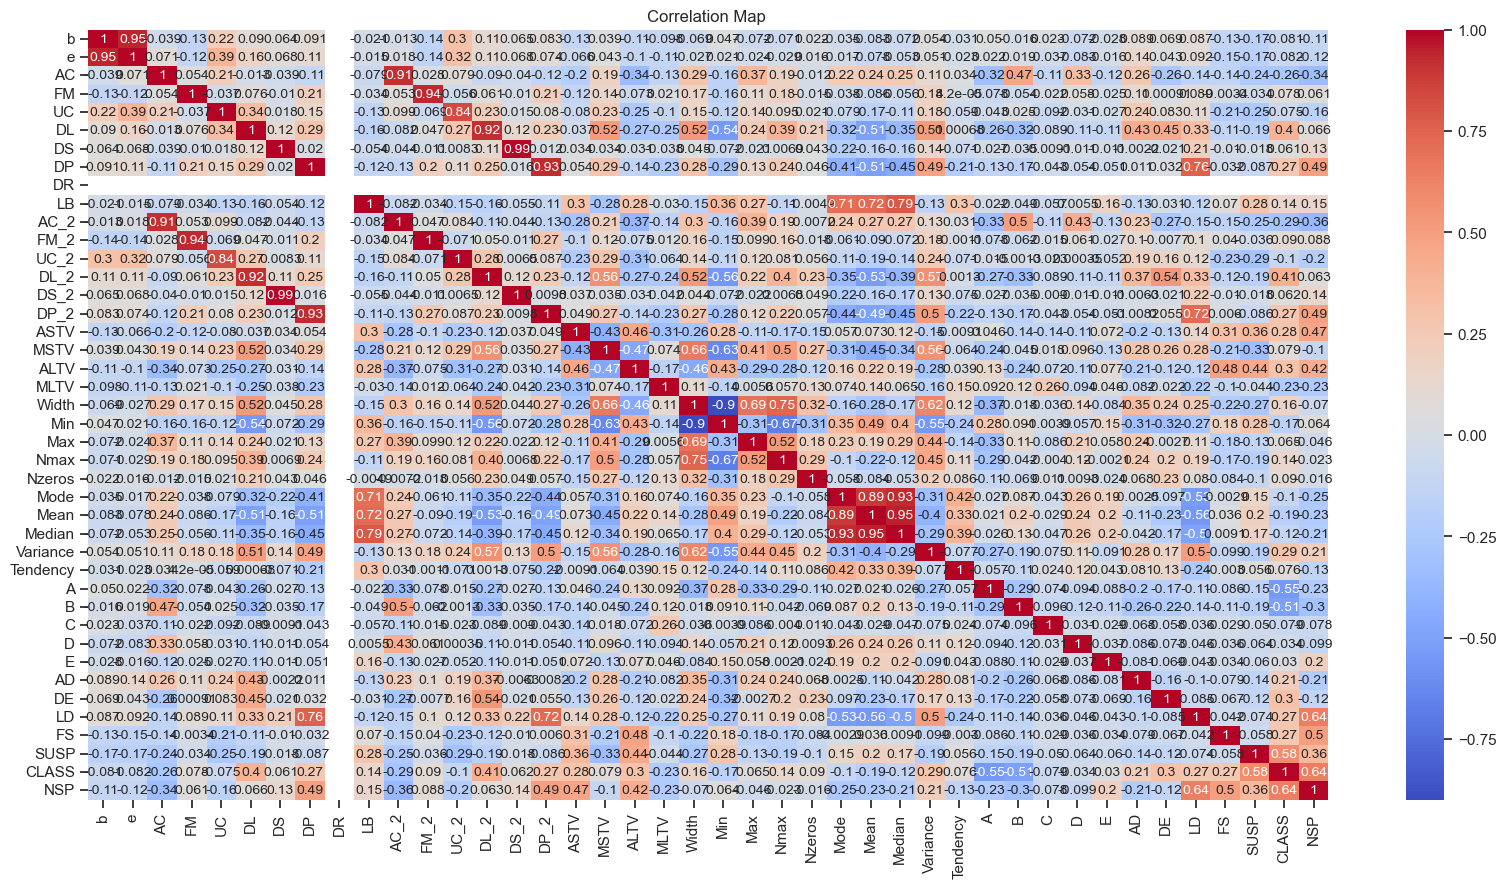

<Figure size 500x300 with 0 Axes>

In [65]:
# correlation map
# Plot correlation map
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plotCorrMap(df1, df1.columns, "", axs)

From this correlation map,
- Most notably, the mean, median, and mode have strong positive correlations, suggesting that the data distribution is relatively symmetric; indicating that it does not have a strong skewness present. Despite this, it does not reveal much about the shape of individual distributions
- As there are many features, it would be hard to analyze much out of this correlation map

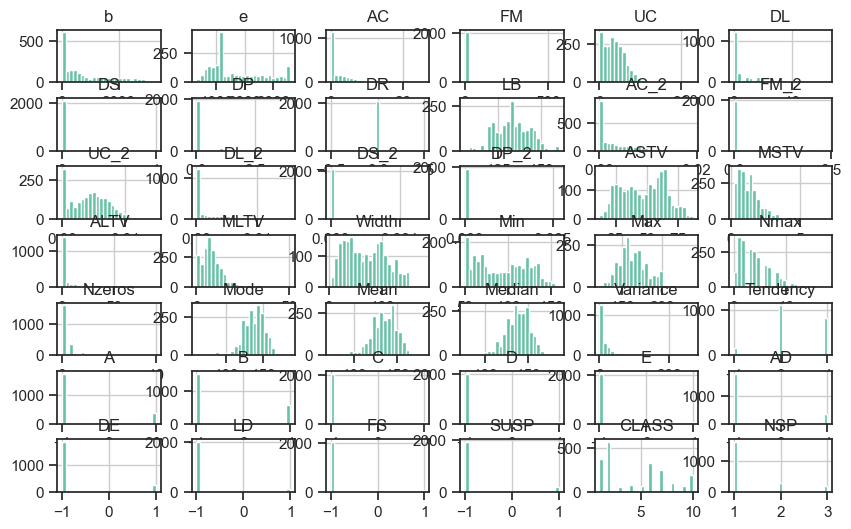

In [66]:
# Shows overall distibution of each column
df1.hist(bins=25,figsize=(10,6)) # Plot histogram
plt.show()

Can be seen that generally, the features are skewed in nature, low distribution across and data points occurring in the tails of the distribution.
- Essential to consider how skewness and distribution may influence relationships and the overall insights derived from the data
- Bias or relationship?

#### Functions

In [67]:
# Functions that return percentages
def calculate_univariate_percentages(df, x):
    # Calculate total counts for each unique value in column x
    totalCounts = df[x].value_counts().to_dict()
    # Calculate percentages
    total_rows = len(df)
    percentages = {k: f"{round((v / total_rows) * 100, 3):.3f}%" 
                   for k, v in totalCounts.items()}
    return percentages

def calculate_pairwise_percentages(df, x, hue):
    # Calculate total counts for each unique value in x and hue
    counts = df.groupby([hue, x]).size().unstack(fill_value=0)
    
    # Calculate percentages for each category in hue (TypeName)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    return percentages

def calculate_count_percentages(df, x, col):
    # Calculate total counts (sum of all values in column x)
    totalCounts = df[x].sum()
    
    # Calculate percentages
    percentages = {row[col]: f"{(row[x] / totalCounts) * 100:.3f}%" 
                   for index, row in df.iterrows()}
    
    return percentages
# Functions that deal with graphs and visualizations
def setTitleLabels(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
# Plots a table beside graph
def plotTable(ax, table_data):
    # Convert dictionary to a list of lists for Matplotlib table
    table_data_list = [[key, value] for key, value in table_data.items()]

    # Add the table to the plot and adjust size
    table = ax.table(cellText=table_data_list, loc='right', bbox=[1.1, 0.2, 0.99, 0.7])
    return table
    
# Plots histograms and annotates with counts accordingly
def plotHist(df, x, hue, title, xlabel, ylabel, table_data ,remove_legend=True,):
    # Plot barplots
    plt.figure(figsize=(7, 4))
    ax = sns.histplot(data=df, x=x, hue=hue, 
                      multiple="dodge", palette="pastel", label="legend")
    
    # Calculate values manually
    totalCounts = df[hue].value_counts().to_dict()
    
    # Annotate each bar
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # Only annotate bars with a height greater than 0
            ax.annotate(f'{height:.0f}', 
                        xy=(patch.get_x() + patch.get_width() / 2, height), 
                        xytext=(0, -3),
                        textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10, color='black', weight='bold')

    # Set the title and labels
    setTitleLabels(title, xlabel, ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a faint grid for readability 
    ax.set_ylim(0, max(df[hue].value_counts()) + 1000)
    
    # Plot a table within the graph to show data
    plotTable(ax, table_data)
    if remove_legend:
        ax.legend().remove()
    plt.show()
    
# Plots BoxPlots
def plotBoxPlot(list_table, df, x, y, hue, title, xlabel, ylabel):
    # Create boxplot
    plt.figure(figsize=(7, 3))
    ax = sns.boxplot(data=df, x=x, y=y, hue=hue, width=0.5)
    if hue is not None:
        plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    if list_table is not None:
        plotTable(ax, list_table)
    # Add labels and title
    setTitleLabels(title, xlabel, ylabel)
    plt.show()
    return ax
    
def plotReplot(df, x, y, hue, size, dotSize ,title):
    sns.relplot(x=x, y=y, 
                hue=hue, size=size,
                sizes=dotSize, alpha=0.15, palette="muted",
                height=3, aspect=3, data=df)
    plt.title(title)
    plt.show()

# Plot stacked bar plot
def plotStacked(df, index, col, title, xlabel, ylabel):
    Counts = df.groupby([index,col]).size().reset_index(name='Count')

    pivotData = Counts.pivot(index=index, columns=col, values='Count')

    # Normalize the data to percentage
    pivotData = pivotData.div(pivotData.sum(axis=1), axis=0) * 100

    # Create a stacked bar plot
    plt.figure(figsize=(3,1))
    ax = pivotData.plot(kind='bar', stacked=True)

    # Set the labels and title
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    setTitleLabels(title, xlabel, ylabel)

    # Set the y-axis tick format to show percentages
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.set_ylim(0, 100)
    # Set the legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

#### 2. Feature Analysis

#### Zooming in on NSP
Firstly, taking a look at NSP, and exploring univariate and bivariate relationships

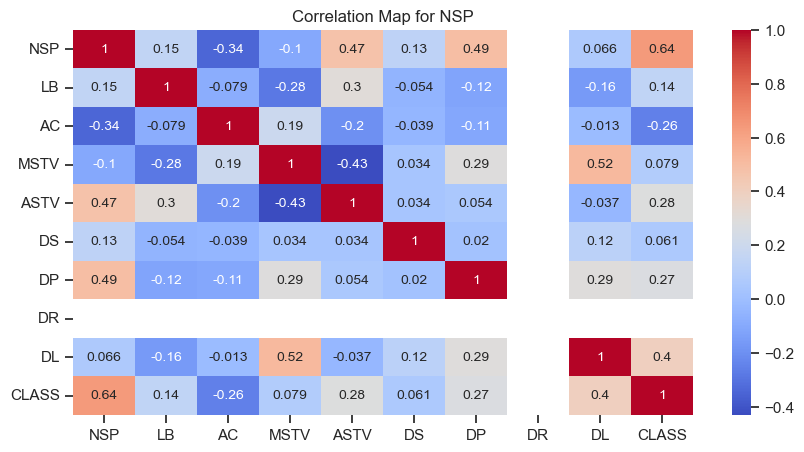

<Figure size 500x300 with 0 Axes>

In [68]:
# Look at cols that attribute by basing off design choice terms
df_NSP = df1[['NSP','LB','AC','MSTV','ASTV','DS','DP','DR','DL','CLASS']]
# Plot correlation map
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plotCorrMap(df_NSP, df_NSP.columns, "for NSP", axs)

Looking at this correlation map,
- NSP has the strongest positive correlation with CLASS (0.64) suggesting that the higher the CLASS code (1-10), the higher the NSP score (1-3)
- ASTV and DR have a strong positive correlation with NSP, with 0.47 and 0.49 respectively, signifying that they could be good predictors of pathological cases
- DL has a strong positive correlation with MSTV as DL ( light decelerations ) often co-occur with fluctuations in FHR, which increases short-term variability.

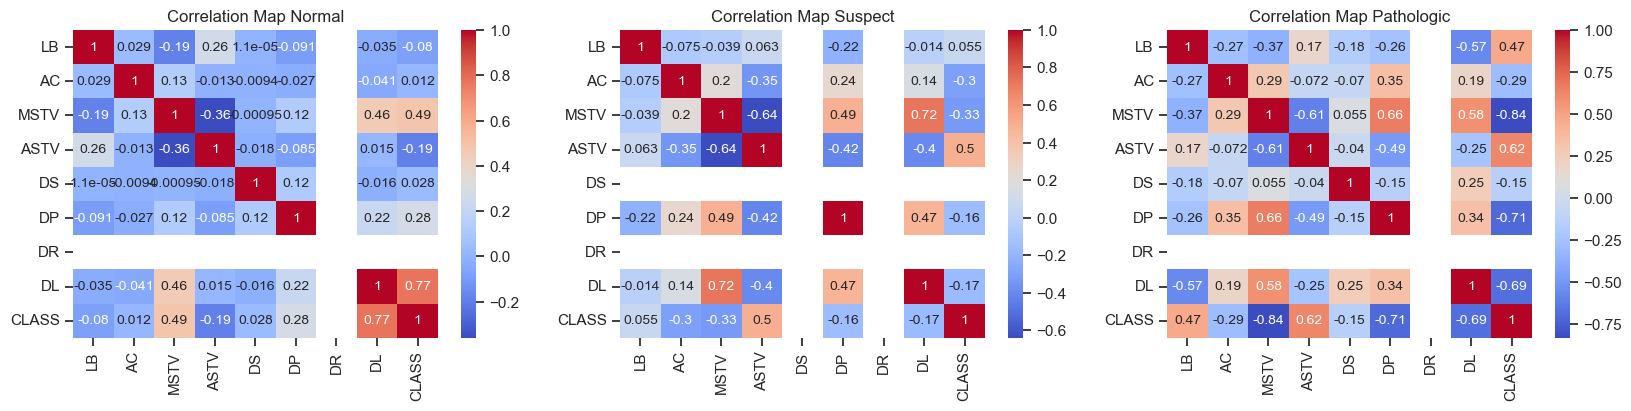

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

In [69]:
# Get df for N/S/P
NSP_1 = df1[df1['NSP']==1]
NSP_2 = df1[df1['NSP']==2]
NSP_3 = df1[df1['NSP']==3]

# Filter to columns attribute by basing off design choice terms
columns = ['LB','AC','MSTV','ASTV','DS','DP','DR','DL','CLASS']

# Plot correlation maps
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
plotCorrMap(NSP_1, columns, "Normal", axs[0])
plotCorrMap(NSP_2, columns, "Suspect", axs[1])
plotCorrMap(NSP_3, columns, "Pathologic", axs[2])
plt.show()

For normal,
- LB-AC -> low pos correlation (+0.03) -> baseline and accelerations essentially independent
- DL-CLASS -> strong pos correlation (+0.77) -> frequency light decelerations is strongly associated with normal CLASSes.
- AC-MSTV -> low pos correlation (+0.13)  -> low correlation means they do not always co-occur
- ASTV -MSTV -> moderate neg correlation (-0.36) -> ASTV increases, MSTV decreases
- Deceleration metrics are mostly near zero, indicating decelerations are rare or minimal in normal CTGs

For suspect
- LB-AC -> low pos correlation (-0.076) -> baseline and accelerations are essentially independent, with a very weak negative trend
- DL-CLASS -> low neg correlation (-0.17) -> mild decelerations may start appearing not yet strongly predictive of severe distress
- ASTV -MSTV -> high neg correlation (-0.64) -> ASTV strongly reduces MSTV
- DL-DP -> moderate pos correlation (+0.47) -> presence of any deceleration type may hint at increasing fetus compromise
- DL-MSTV -> high pos correlation (+0.72) ->  DL strongly co-occur with MSTV
- DP-MSTV -> high pos correlation (+0.49) -> DP tend to co-occur with MSTV

For pathologic
- LB-AC -> low neg correlation (-0.27) -> higher baseline is weakly associated with fewer accelerations
-  DL-CLASS -> strong neg correlation (-0.69) -> DL inversely associated with CLASS
- ASTV -MSTV -> high neg correlation (-0.61)  -> reinforces significant compromise
- LB-CLASS -> moderate pos correlation (+0.47) -> higher baseline is moderately associated with CLASS
- DL-DP -> moderate pos correlation (+0.34) -> presence of any deceleration type may hint at increasing fetus compromise
- DL-MSTV -> high pos correlation (+0.59) -> DL tend to co-occur with MSTV
- DP-MSTV -> high pos correlation (+0.66) -> DP strongly co-occur with MSTV

Overall,
- Deceleration markers are highly important in CTG interpretation
- Variability (ASTV-MSTV) -> stronger negative indicates compromise
- Reactivity (LB-AC) -> declines with severity

In [70]:
columns = ['LB','AC','MSTV','ASTV','DS','DP','DR','DL','CLASS']
# Create an aggregated df to analyze in tableform
NSPagg = df1.groupby(['NSP', 
                         ]).agg({columns[0]: 'median',
                                 columns[1]: 'median',
                                 columns[2]: 'median',
                                 columns[3]: 'median',
                                 columns[4]: 'median',
                                 columns[5]: 'median',
                                 columns[6]: 'median',
                                 columns[7]: 'median',
                                 columns[8]: 'median',
                                }).reset_index()
NSPagg

,NSP,LB,AC,MSTV,ASTV,DS,DP,DR,DL,CLASS
0,1.0,132.0,2.0,1.3,41.0,0.0,0.0,0.0,0.0,2.0
1,2.0,143.0,0.0,0.4,63.0,0.0,0.0,0.0,0.0,10.0
2,3.0,132.0,0.0,1.7,65.0,0.0,1.0,0.0,2.0,8.0


From this table,
- Affirms the relationship between MSTV-ASTV where normal (1.3-41.0) suggests moderate variability with minimal abnormality; suspect (0.4-63.0) suggests flat and abnormal; pathological (1.7-65.0) suggests low variability with high abnormality
- The median LB for S/P are normal which are deceptive, which will be explored further later on
- No accelerations (AC) -> non-reactive

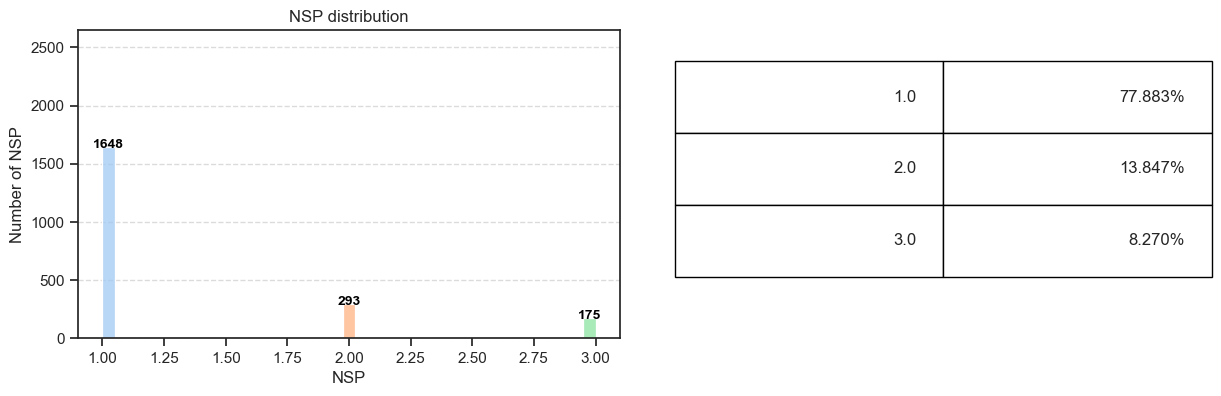

In [71]:
# Look at the distribution of NSP
percentages = calculate_univariate_percentages(df1, "NSP")
plotHist(df1, "NSP", "NSP","NSP distribution", 
         "NSP", "Number of NSP", percentages)

NSP represents the CTG outcomes, whereby Normal=1; Suspect=2; Pathologic=3

The distribution of N/S/P is skewed with Normal cases comprising (77.846%) of all records, this class imblance reflects real-world hospitals where most fetuses are healthy, so normal CTG patterns vastly outnumber suspect or pathologic ones

##### Relationship between NSP and CLASS

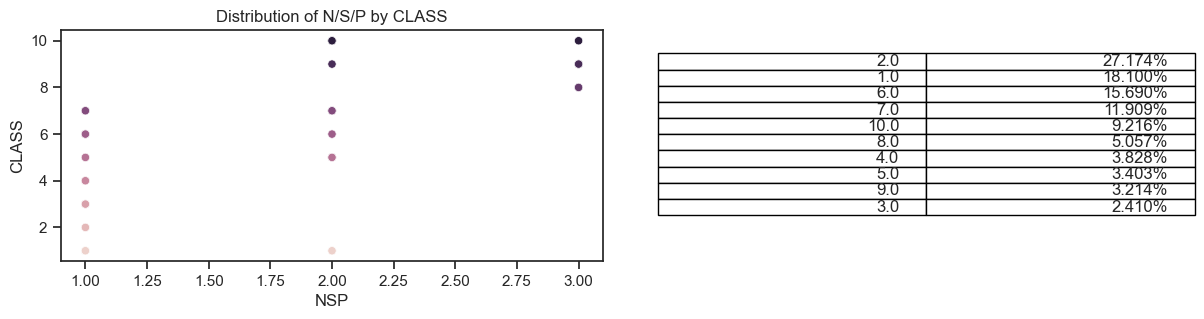

In [72]:
plt.figure(figsize=(7, 3)) 

# Scatterplot to plot between relationships
ax = plt.gca()
sns.scatterplot(data=df1, x="NSP", 
                y="CLASS", hue="CLASS")
percentages = calculate_univariate_percentages(df1, 'CLASS')
plotTable(ax, percentages)
ax.get_legend().remove()
plt.title("Distribution of N/S/P by CLASS")
plt.show()

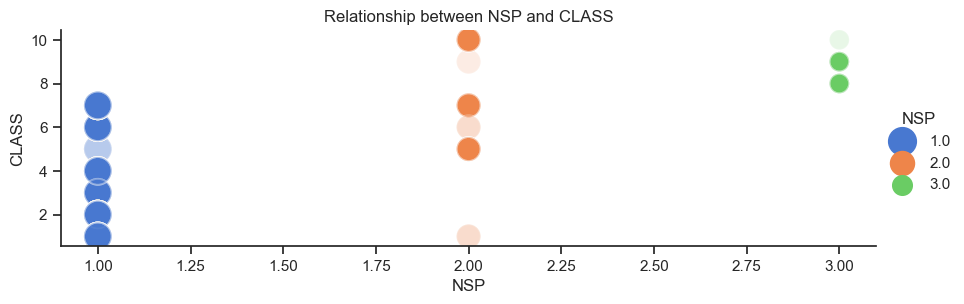

In [73]:
plotReplot(df1, "NSP", "CLASS",
           "NSP", "NSP", (400,200),
           "Relationship between NSP and CLASS")

For normal,
> Concentrated in lower CLASS values 1-7, low % in CLASS 5

For suspect,
> Some overlap with both normal and pathologic ranges, low %s in CLASSes 1, 6 & 9

For pathologic,
> Concentrated in upper CLASS values 8-10, low % in CLASS 10

Indicating a well-structured relationship between NSP and CLASS, suggesting that there is a clear separation between normal and pathologic status of patients; suspect stasuses have a wider spread across CLASS values, requiring additional clinical context to correctly label and come to the decision of classifying the patient as normal or pathologic

##### Relationship between NSP and (MSTV-ASTV)

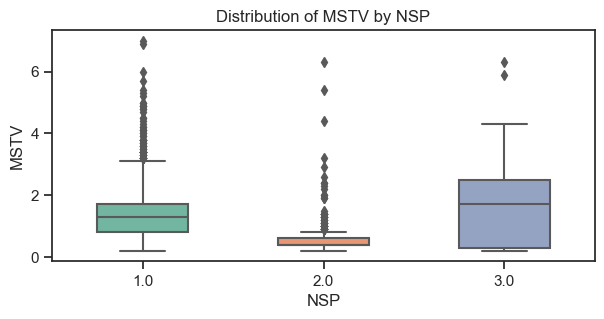

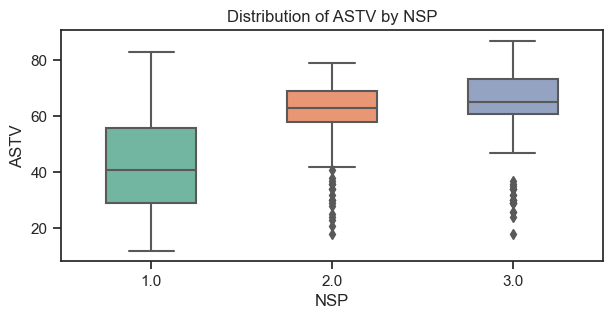

In [74]:
plotBoxPlot(None, df1,"NSP","MSTV", None,
            "Distribution of MSTV by NSP",
            "NSP","MSTV")
plotBoxPlot(None, df1,"NSP","ASTV", None,
            "Distribution of ASTV by NSP",
            "NSP","ASTV")
plt.show()

As explored in the correlation map, variability (ASTV-MSTV) -> stronger negative indicates compromise

- Very low MSTV is rare in healthy fetuses
- Suspect fetuses have a severely compressed core; indicating that majority of fetuses have MSTV of lower than ~<0.6
- Pathological fetuses has a broad plot, which could be attributed to early-stage and end-stage patterns 
- There is a clear distinction in N/S/P ASTV; ASTV > 60 is a strong discriminator between normal and pathologic statuses

#### Relationship between NSP and (LB-AC)

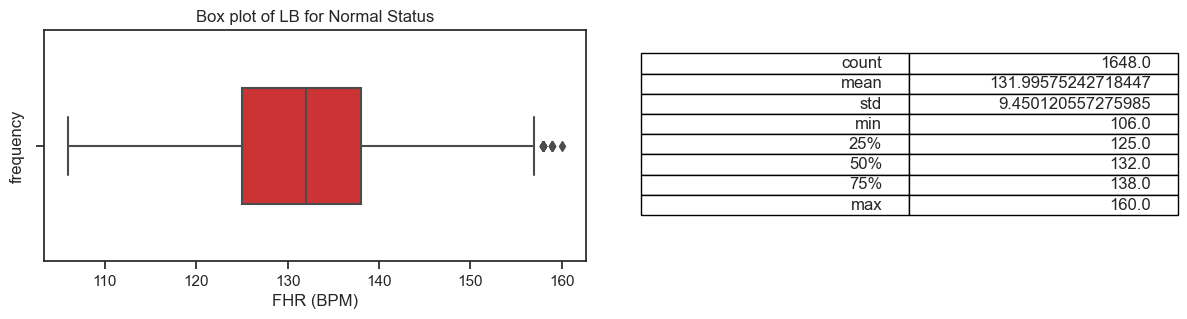

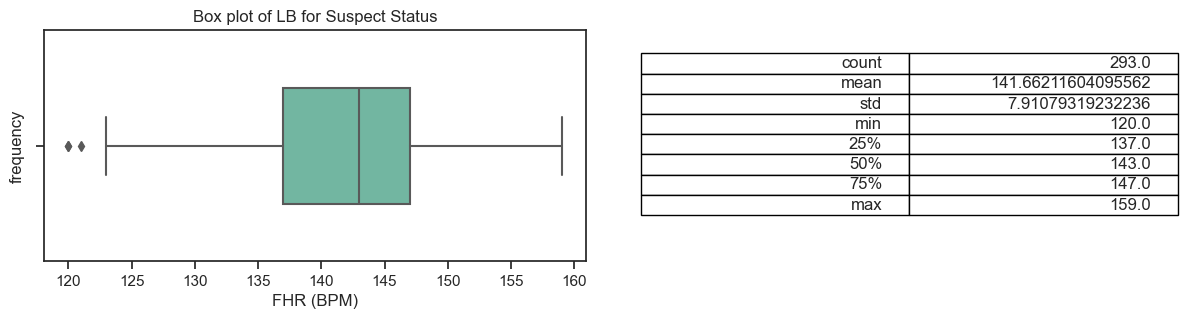

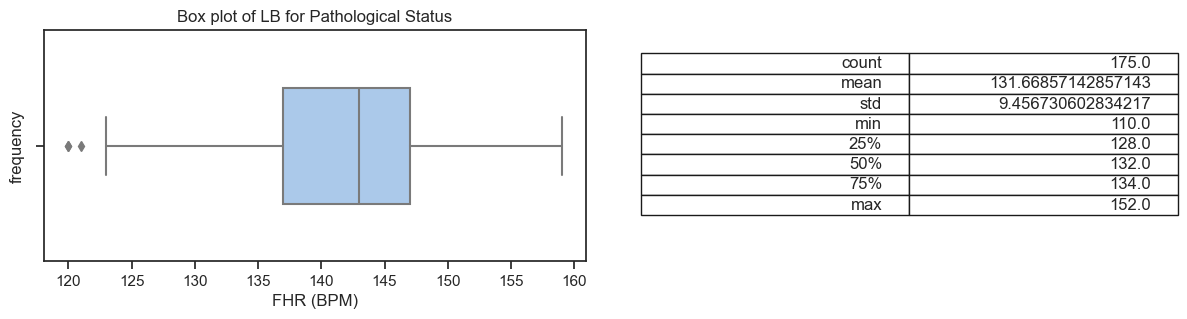

In [75]:
# Set theme for graphs
sns.set_theme(style="ticks", palette="Set1")
# Plot box plot for each LB
plotBoxPlot(df1[df1['NSP']==1]['LB'].describe().to_dict(), 
            NSP_1, "LB", None, None, 
            "Box plot of LB for Normal Status", "FHR (BPM)", "frequency")
sns.set_theme(style="ticks", palette="Set2")
plotBoxPlot(df1[df1['NSP']==2]['LB'].describe().to_dict(), 
            NSP_2, "LB", None, None, 
            "Box plot of LB for Suspect Status", "FHR (BPM)", "frequency")
sns.set_theme(style="ticks", palette="pastel")
plotBoxPlot(df1[df1['NSP']==3]['LB'].describe().to_dict(), 
            NSP_2, "LB", None, None, 
            "Box plot of LB for Pathological Status", "FHR (BPM)", "frequency")
sns.set_theme(style="ticks", palette="Set2")
fig.suptitle("Box plots for LB by NSP", fontsize=12, y=1.06)
plt.show()

For normal -> min of 106BPM, max of 160BPM -> median of 132BPM
- Has a wider range, and more symmetrical in shape

For suspect -> min of 120BPM, max of 159BPM -> median of 143BPM
- Has lesser range, and elevated baseline
- Suspect fetuses show distinctly elevated heart rates
- No suspect records below 120BPM suggesting that suspect fetuses likely cannot achieve low baseline BPMs

For pathological -> min of 110BPM, max of 152BPM -> median of 132BPM
- Has a slightly more range
- The median is deceptive as it is the same as Normal status fetuses
- The median could be supressed due to the fetuses experiencing decompensated tachycardia (140-152BPM) or terminal bradycardia (110-120BPM)

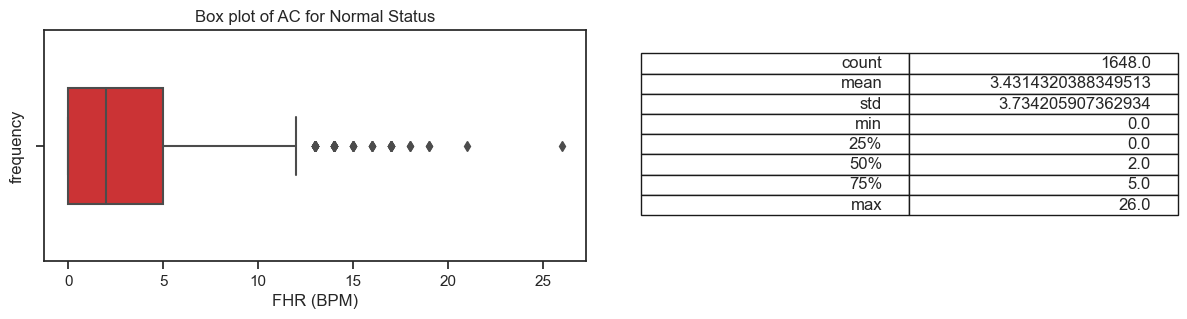

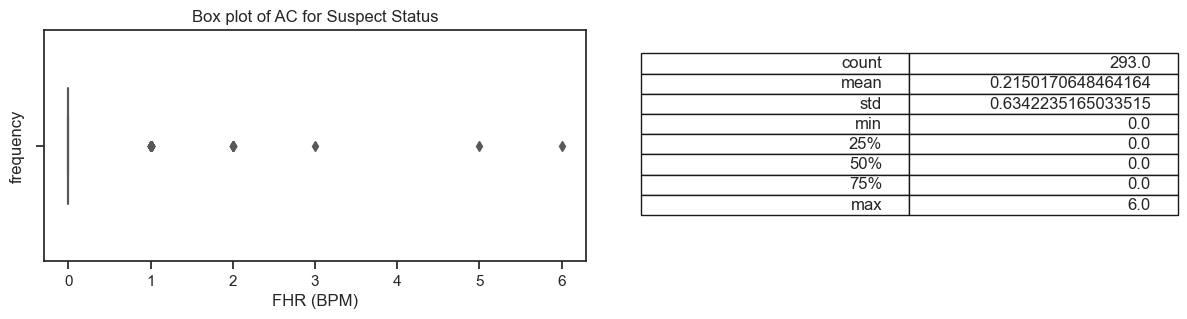

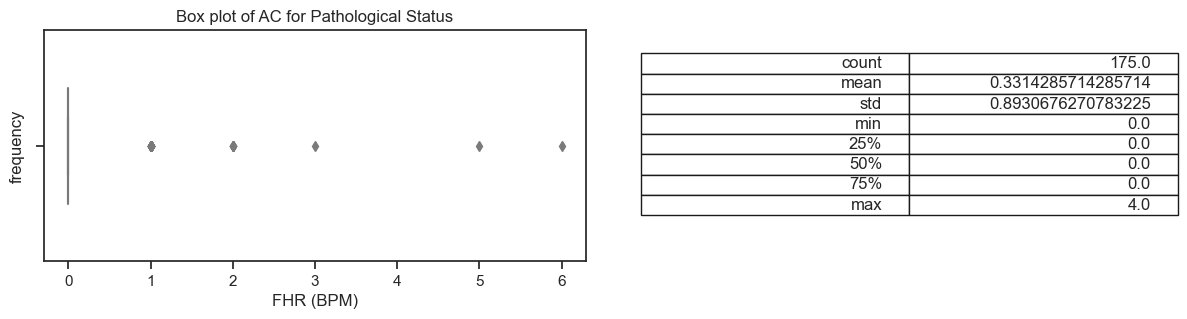

In [76]:
# Set theme for graphs
sns.set_theme(style="ticks", palette="Set1")
# Plot box plot for each LB
plotBoxPlot(df1[df1['NSP']==1]['AC'].describe().to_dict(), 
            NSP_1, "AC", None, None, 
            "Box plot of AC for Normal Status", "FHR (BPM)", "frequency")
sns.set_theme(style="ticks", palette="Set2")
plotBoxPlot(df1[df1['NSP']==2]['AC'].describe().to_dict(), 
            NSP_2, "AC", None, None, 
            "Box plot of AC for Suspect Status", "FHR (BPM)", "frequency")
sns.set_theme(style="ticks", palette="pastel")
plotBoxPlot(df1[df1['NSP']==3]['AC'].describe().to_dict(), 
            NSP_2, "AC", None, None, 
            "Box plot of AC for Pathological Status", "FHR (BPM)", "frequency")
sns.set_theme(style="ticks", palette="Set2")
fig.suptitle("Box plots for AC by NSP", fontsize=12, y=1.06)
plt.show()

For normal -> min of 0, max of 26 -> median of 2

For suspect -> min of 0, max of 6 -> median of 0
- Indicating abnormalies

For pathological -> min of 0, max of 4 -> median of 0
- Indicating abnormalies

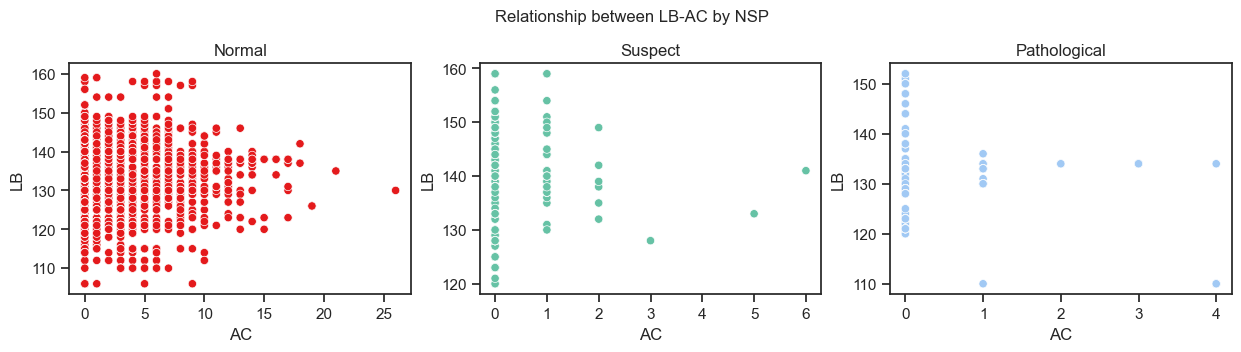

In [77]:
# Create scatterplots
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot scatterplot between AC, and LB
sns.scatterplot(ax=ax[0],data=NSP_1, x="AC", 
                y="LB", hue="NSP", palette="Set1",
                legend=False)
ax[0].set_title("Normal")
sns.scatterplot(ax=ax[1],data=NSP_2, x="AC", 
                y="LB", hue="NSP", palette="Set2",
                legend=False)
ax[1].set_title("Suspect")
sns.scatterplot(ax=ax[2],data=NSP_3, x="AC", 
                y="LB", hue="NSP", palette="pastel",
                legend=False)
ax[2].set_title("Pathological")
fig.suptitle("Relationship between LB-AC by NSP", fontsize=12, y=1.06)
plt.show()

For normal -> AC ranging from 0-25 -> dense & broad distribution -> LB range 110-160BPM
- AC occurs at all baseline levels, with no clear correlation pattern
- Varied, with high acceleration 

For suspect -> AC ranging from 0-6 -> scattered & concentrated at 0 -> LB range 120-160BPM
- 83% reduction from normal maximum
- Loss of AC + high LB is a suspect pattern

For pathological -> AC ranging from 0-4 -> concentrated at 0 -> LB range 110-150BPM
- Severe non-reactive pattern

#### Relationship between NSP and Decelerations

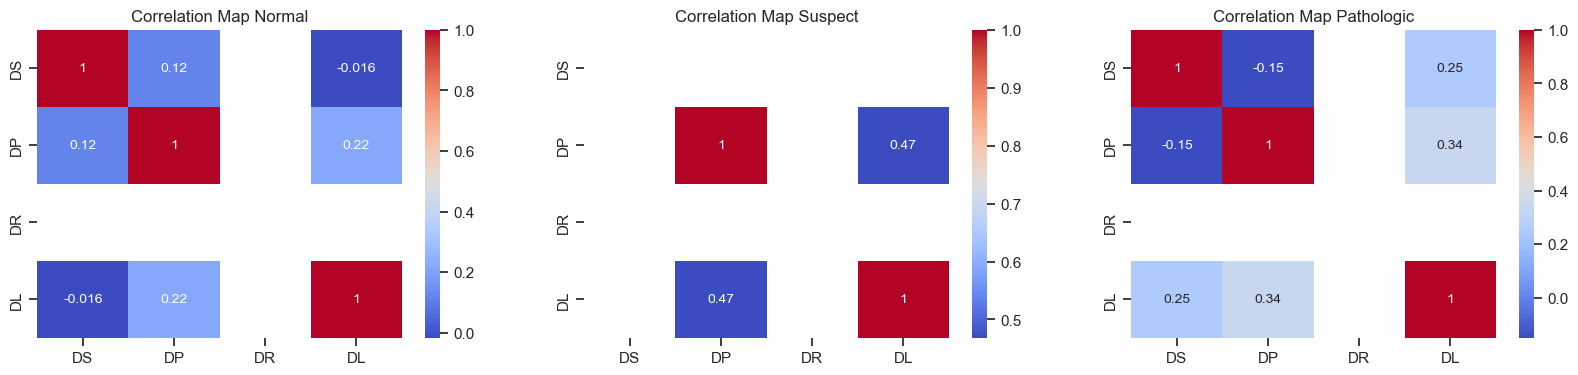

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

In [78]:
# Filter to columns relating to decelerations
columns = ['DS','DP','DR','DL']

# Plot correlation maps
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
plotCorrMap(NSP_1, columns, "Normal", axs[0])
plotCorrMap(NSP_2, columns, "Suspect", axs[1])
plotCorrMap(NSP_3, columns, "Pathologic", axs[2])
plt.show()

###### Analysis on DL-DP relationship

<Figure size 300x100 with 0 Axes>

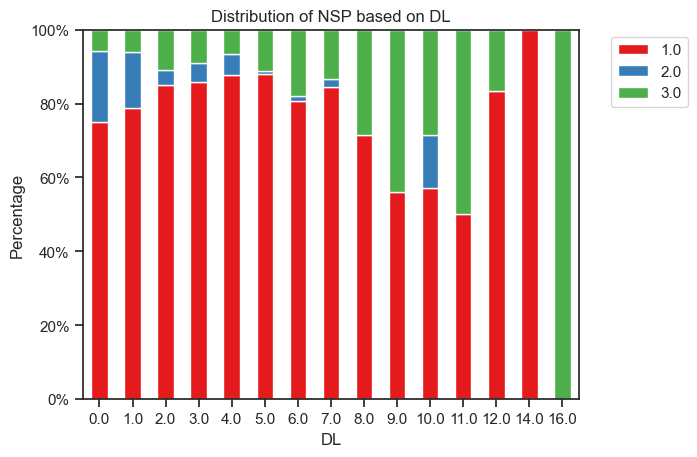

In [79]:
# Create stacked plots
sns.set_theme(style="ticks", palette="Set1")
plotStacked(df1, 'DL', 'NSP',
            "Distribution of NSP based on DL", 
            "DL","Percentage")

For normal -> DL ranging from 0-14

For suspect -> AC ranging from 0-10

For pathological -> AC ranging from 0-16

- Not much difference in DL to distinguish between N/S/P

<Figure size 300x100 with 0 Axes>

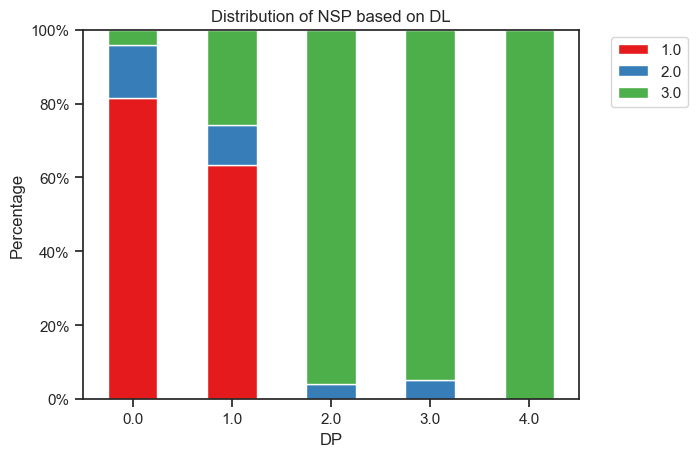

In [81]:
sns.set_theme(style="ticks", palette="Set1")
plotStacked(df1, 'DP', 'NSP',
            "Distribution of NSP based on DL", 
            "DP","Percentage")

For normal -> DP ranging from 0-1
- Suggesting DP is rare or nearly absent in healthy fetuses

For suspect -> DP ranging from 0-3
- Suggesting DP begins to appear more frequently

For pathological -> DP ranging from 0-4
- Suggesting decelerations occur more frequently and are more significant

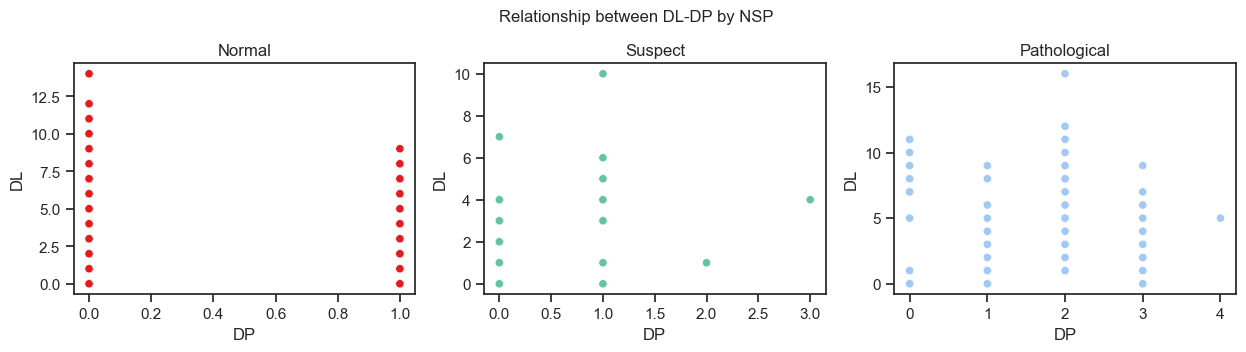

In [82]:
# Create scatterplots for distribution + relationship
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot scatterplot between AC, and LB
sns.scatterplot(ax=ax[0],data=NSP_1, x="DP", 
                y="DL", hue="NSP", palette="Set1",
                legend=False)
ax[0].set_title("Normal")
sns.scatterplot(ax=ax[1],data=NSP_2, x="DP", 
                y="DL", hue="NSP", palette="Set2",
                legend=False)
ax[1].set_title("Suspect")
sns.scatterplot(ax=ax[2],data=NSP_3, x="DP", 
                y="DL", hue="NSP", palette="pastel",
                legend=False)
ax[2].set_title("Pathological")
fig.suptitle("Relationship between DL-DP by NSP", fontsize=12, y=1.06)
plt.show()

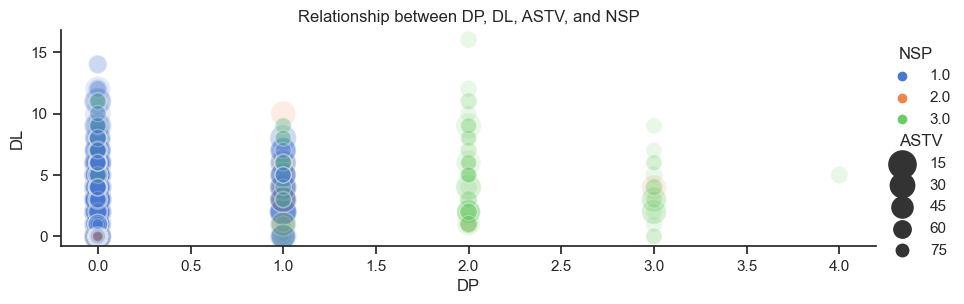

In [83]:
plotReplot(df1, "DP", "DL",
           "NSP", "ASTV", (400,20),
           "Relationship between DP, DL, ASTV, and NSP")

### Conclusion of EDA
-----
Through the EDA, relationships and correlations could be uncovered, allowing impactful insights to be made towards understanding the complex, multi-dimensional nature of fetal well-being and CTGs. Which can result in a better ML model and ultimately helping medical practioners make informed decisions that is based on accuracy, precision, and reliability.

- Bias and skewness is easily introduced due to the sheer number Normal status fetuses domineering the dataset
- We have discovered that there are signature patterns that distinguish normal, suspect, and pathologic fetal statuses

In [84]:
# Feature selection
# Based on EDA, these are the important features to be trained on,
df1 = df1[['NSP','LB','AC','MSTV','ASTV','DS','DP','DR','DL','Variance', 'Tendency',]]

In [ ]:
df1.to_excel("transformedCTG.xlsx", index=False)

## 3. Model Pipeline

In [344]:
# Import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

In [233]:
# Functions
def measure_error(y_true, y_pred, label):
    return pd.Series({
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'), 
        'recall': recall_score(y_true, y_pred, average='weighted'),       
        'f1': f1_score(y_true, y_pred, average='weighted'
                      )}, name=label)
def get_model_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print('Classification Report of model:', report)

def get_confusion_matrix(y_true, y_pred, plot_heatmap=True):
    # compute and print the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix:\n', cm)
    if plot_heatmap:
        # plot the confusion matrix as a heatmap
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
def get_validation_accuracy(clf, X_val, y_val):
    accuracy = clf.score(X_val, y_val)
    print()
    print(f"\nValidation Accuracy: {accuracy}")
    print()
    
def model_accuracy(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    print("Cross-validated accuracy: {:.2f} ± {:.2f}".format(scores.mean(), scores.std()))
def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    # Get Model classification report
    get_model_classification_report(y_test, y_pred)
    # Get Confusion Matrix
    get_confusion_matrix(y_test, y_pred)
    
def plot_multiclass_roc(clf, X_test, y_test, class_labels, model_name="Model"):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=class_labels)
    n_classes = y_test_bin.shape[1]
    # Predict probabilities
    y_score = clf.predict_proba(X_test)
    # Compute ROC curve and AUC for each class
    fpr = dict() ; tpr = dict() ; roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'darkorange', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0} = {1:0.4f}'.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'Multiclass ROC - {model_name}', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.show()
    print(f"{model_name} AUC Summary\n{(lambda x: '.'*40)(None)}")
    print(f'Micro-average AUC = {roc_auc["micro"]:0.4f}')
    print(f'Macro-average AUC = {roc_auc["macro"]:0.4f}')
    
def evaluation_metrics(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    print(get_confusion_matrix(y_train, y_train_pred))
    print()
    print("Classification Report")
    print(classification_report(y_train, y_train_pred))
    print()

    # Get probability estimates for all classes
    y_probs = clf.predict_proba(X_test)
    
    # Compute AUC score for multiclass
    try:
        auc_score = roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro')
        print("AUC score = {:.5f}".format(auc_score))
    except Exception as e:
        print("Error computing AUC:", e)
    
    # Compute cross-validated ROC AUC
    cv_roc_auc = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc_ovr')
    print(f'Cross-validated ROC AUC: {cv_roc_auc.mean()}')

    # Train/test errors
    train_test_full_error = pd.concat([
        measure_error(y_train, y_train_pred, 'train'),
        measure_error(y_test, y_test_pred, 'test')
    ], axis=1)
    print(train_test_full_error)
    
# Returns the top 5 feature importances
def top5_feature_importances(clf, feature_cols):
    feature_imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("Top 5 feature importances")
    print(feature_imp.head())
    print()
    
def tableFormat(model, X, y_true=None, adjust_labels=True):
    # Predict classes
    y_pred = model.predict(X)
    # Predict probabilities
    y_probs = model.predict_proba(X)
    # Adjust labels back to original (if labels were offset by -1)
    if adjust_labels:
        y_pred = y_pred + 1
    # Create probability columns

    prob_df = pd.DataFrame(
        y_probs * 100, 
        columns=[f"Prob_Class_{i+1} (%)" for i in range(y_probs.shape[1])]
    )
    
    results_df = pd.DataFrame({'Predicted_Class': y_pred})
    final = pd.concat([results_df, prob_df], axis=1) # concat together
    if y_true is not None:
        final.insert(0, 'Actual_Class', y_true)
        final['Correct'] = (final['Predicted_Class'] == final['Actual_Class'])
    
    return final

def plotAcc(title,base_rf_clf, d_1, d_2, b_=True):
    print(f"{title}\n{(lambda x: '.'*40)(None)}")
    # Segregate by value counts
    sizes1 = tableFormat(base_rf_clf, d_1, d_2 , b_)[tableFormat(base_rf_clf, d_1, d_2, b_)["Actual_Class"]==1.0]['Correct'].value_counts()
    sizes2 = tableFormat(base_rf_clf, d_1, d_2, b_)[tableFormat(base_rf_clf, d_1, d_2, b_)["Actual_Class"]==2.0]['Correct'].value_counts()
    sizes3 = tableFormat(base_rf_clf, d_1, d_2, b_)[tableFormat(base_rf_clf, d_1, d_2, b_)["Actual_Class"]==3.0]['Correct'].value_counts()
    labels = ["Correct", "Incorrect"]
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    ax[0].pie(sizes1, labels=labels, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
    ax[0].set_title("CLASS 1 (N)")
    ax[1].pie(sizes2, labels=labels, autopct='%1.1f%%', colors=['#99ff99', '#ffcc99'])
    ax[1].set_title("CLASS 2 (S)")
    ax[2].pie(sizes3, labels=labels, autopct='%1.1f%%', colors=['#c2c2f0', '#ffb3e6'])
    ax[2].set_title("CLASS 3 (P)")
    fig.suptitle(f"Model Prediction Accuracy by class for {title}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [35]:
# Get df
df = pd.read_excel("transformedCTG.xlsx")

# Initial steps of Data Preprocessing already fulfilled in EDA such as feature selection

# Split into float columns to scale
# Robust scaler for numerical
float_cols = [col for col in df.columns if col in df.columns and col != 'NSP']
df_ = df.astype('float64') # Convert all to float64

scaler = RobustScaler()
df_[float_cols] = scaler.fit_transform(df_[float_cols])
print(f'After scaling =\n',df_.head())

# Split into X and y
X = df_.drop(columns=['NSP'])
y = df_['NSP']


# Apply SSS to split data into test train and validation
def stratified_split(X, y, train_size=0.7, val_size=0.2, test_size=0.1, random_state=42):
    # First split: train+val and test
    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(sss_test.split(X, y))
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

    # Second split: train and validation
    val_fraction_of_train_val = val_size / (train_size + val_size)  # relative fraction
    sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction_of_train_val, random_state=random_state)
    train_idx, val_idx = next(sss_val.split(X_train_val, y_train_val))
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = stratified_split(X, y, 
                                                                  train_size=0.7, val_size=0.2, 
                                                                  test_size=0.1, random_state=42)

print(f"\nTrain, Test and Validation Split 70/20/10\n{(lambda x: '.'*40)(None)}")
print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

# Print to show the size of each set
print()
print('Shape of Train Set:', X_train.shape)
print('Shape of Validation Set:', X_val.shape)
print('Shape of Test Set:', X_test.shape)
print()
print('Length of y_train:', len(y_train))
print('Length of y_val:', len(y_val))
print('Length of y_test:', len(y_test))

feature_cols=[x for x in X.columns]
y_train, y_test, y_val = np.ravel(y_train), np.ravel(y_test), np.ravel(y_val)

After scaling =
    NSP        LB    AC  MSTV      ASTV   DS   DP   DR        DL  Variance  \
0  2.0 -0.928571 -0.25  -0.7  0.827586  0.0  0.0  0.0  0.000000  3.000000   
1  1.0 -0.071429  0.75   0.9 -1.103448  0.0  0.0  0.0  0.666667  0.227273   
2  1.0  0.000000  0.25   0.9 -1.137931  0.0  0.0  0.0  0.666667  0.272727   
3  1.0  0.071429  0.25   1.2 -1.137931  0.0  0.0  0.0  0.666667  0.272727   
4  1.0 -0.071429  0.75   1.2 -1.137931  0.0  0.0  0.0  0.000000  0.181818   

   Tendency  
0       1.0  
1       0.0  
2       0.0  
3       1.0  
4       1.0  

Train, Test and Validation Split 70/20/10
........................................
Train: (1480, 10) Validation: (424, 10) Test: (212, 10)

Shape of Train Set: (1480, 10)
Shape of Validation Set: (424, 10)
Shape of Test Set: (212, 10)

Length of y_train: 1480
Length of y_val: 424
Length of y_test: 212


In [36]:
# Specify hyperparams for models
model_hyperparams = {
    'rf' : {'n_estimators': 600, "criterion": "gini", "max_features": "log2","max_depth": 30, "min_samples_split": 20, "random_state": 42},
    'xgb' : {'n_estimators': 300, "max_depth": 40, "subsample": 0.2, "colsample_bytree": 0.5, "random_state": 42},
    'dt' : {'class_weight': 'balanced', 'random_state': 42, 'max_depth': 10}
                    }

In [150]:
import time

### Decision Tree

In [151]:
def timer():
    end_time = time.time()
    elapsed_time = end_time - start_time
    print()
    print(f"Elapsed {elapsed_time:.2f} seconds")
    return elapsed_time

Baseline Decision Tree Classifier
........................................
Cross-validated accuracy: 0.88 ± 0.02

Acc, Precision, F1 Score and Recall table
              train      test
accuracy   0.957432  0.844340
precision  0.963523  0.859483
recall     0.957432  0.844340
f1         0.958998  0.849654
Classification Report of model:               precision    recall  f1-score   support

         1.0       0.92      0.89      0.91       165
         2.0       0.53      0.69      0.60        29
         3.0       0.80      0.67      0.73        18

    accuracy                           0.84       212
   macro avg       0.75      0.75      0.74       212
weighted avg       0.86      0.84      0.85       212

Confusion matrix:
 [[147  16   2]
 [  8  20   1]
 [  4   2  12]]


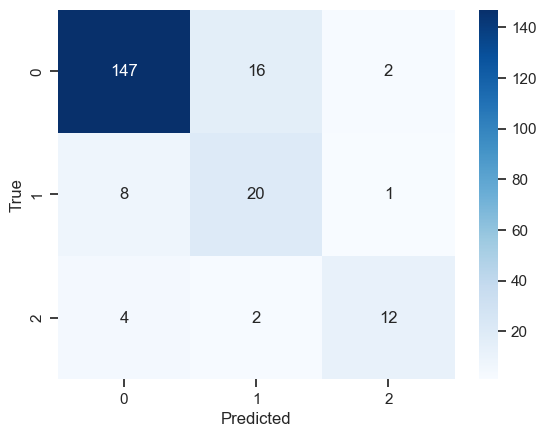



Validation Accuracy: 0.8915094339622641



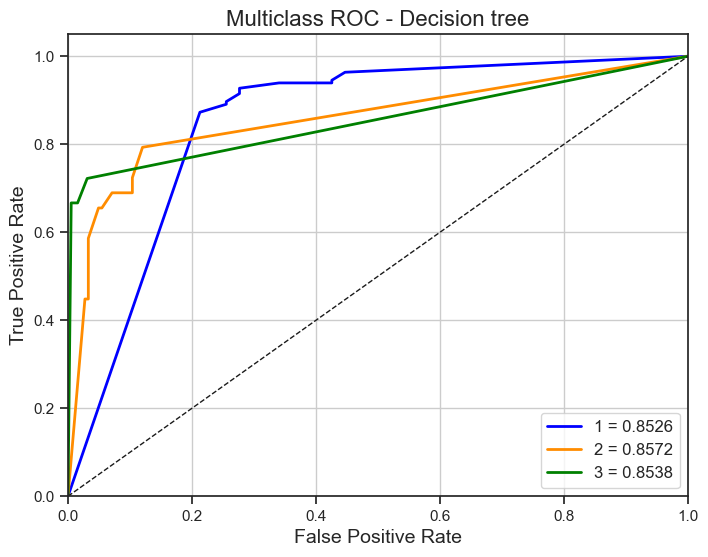

Decision tree AUC Summary
........................................
Micro-average AUC = 0.9307
Macro-average AUC = 0.8548

Elapsed 1.48 seconds


In [152]:
# Basic DT for comparison
start_time = time.time()
from sklearn.model_selection import cross_val_score
print(f"Baseline Decision Tree Classifier\n{(lambda x: '.'*40)(None)}")
params = model_hyperparams['dt']
dt_clf = DecisionTreeClassifier(**params).fit(X_train, y_train)
model_accuracy(dt_clf, X_train, y_train)
print("\nAcc, Precision, F1 Score and Recall table")

y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)
train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
measure_error(y_test, y_test_pred, 'test')],axis=1)
print(train_test_full_error)

evaluate_model(dt_clf, X_test, y_test)
get_validation_accuracy(dt_clf, X_val, y_val)

plot_multiclass_roc(
    clf=dt_clf,
    X_test=X_test,
    y_test=y_test,
    class_labels=[1,2,3],
    model_name="Decision tree"
)
elapsed_time = timer()

### Random Forest

Baseline Random Forest Classifier
........................................
Cross-validated accuracy: 0.91 ± 0.01

Acc, Precision, F1 Score and Recall table
              train      test
accuracy   0.941216  0.896226
precision  0.939373  0.892642
recall     0.941216  0.896226
f1         0.939701  0.891990
Classification Report of model:               precision    recall  f1-score   support

         1.0       0.91      0.96      0.94       165
         2.0       0.75      0.62      0.68        29
         3.0       0.93      0.72      0.81        18

    accuracy                           0.90       212
   macro avg       0.86      0.77      0.81       212
weighted avg       0.89      0.90      0.89       212

Confusion matrix:
 [[159   5   1]
 [ 11  18   0]
 [  4   1  13]]


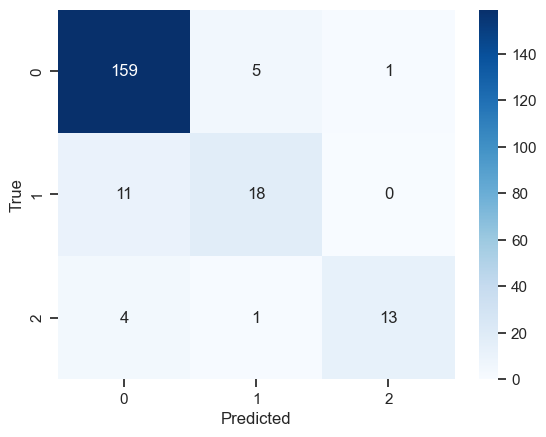



Validation Accuracy: 0.9198113207547169



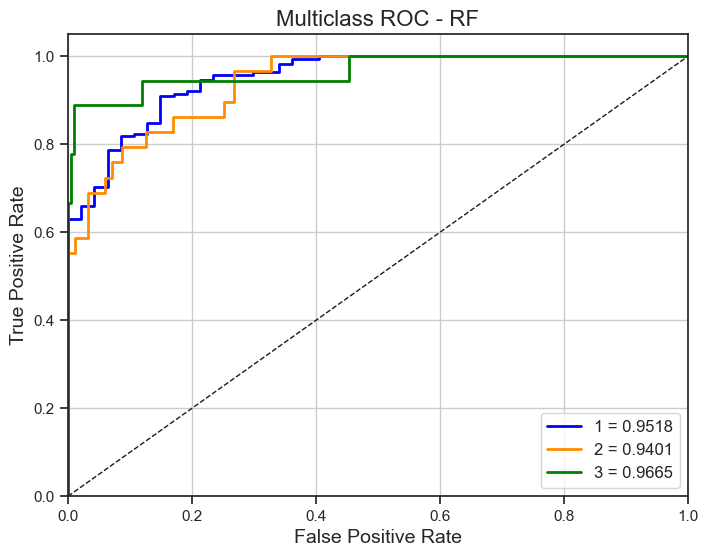

RF AUC Summary
........................................
Micro-average AUC = 0.9786
Macro-average AUC = 0.9553

Elapsed 25.38 seconds


In [164]:
# Basic RF clf for comparison
start_time = time.time()
from sklearn.model_selection import cross_val_score
print(f"Baseline Random Forest Classifier\n{(lambda x: '.'*40)(None)}")
params = model_hyperparams['rf']
base_rf_clf = RandomForestClassifier(**params).fit(X_train, y_train)
model_accuracy(base_rf_clf, X_train, y_train)
print("\nAcc, Precision, F1 Score and Recall table")

y_train_pred = base_rf_clf.predict(X_train)
y_test_pred = base_rf_clf.predict(X_test)
train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
measure_error(y_test, y_test_pred, 'test')],axis=1)
print(train_test_full_error)

evaluate_model(base_rf_clf, X_test, y_test)
get_validation_accuracy(base_rf_clf, X_val, y_val)

plot_multiclass_roc(
    clf=base_rf_clf,
    X_test=X_test,
    y_test=y_test,
    class_labels=[1,2,3],
    model_name="RF"
)
elapsed_time = timer()

Baseline Random Forest Classifier
........................................

Cross-validation scores: [0.90810811 0.92162162 0.89459459 0.92702703]

Acc, Precision, F1 Score and Recall table
              train      test
accuracy   0.941216  0.896226
precision  0.939373  0.892642
recall     0.941216  0.896226
f1         0.939701  0.891990

Performing GridSearch to find best params...

Found the best parameters!

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
Best Cross-validation Accuracy: 0.9195945945945947

RF clf fitted with best params
Cross-validated accuracy: 0.92 ± 0.01


Elapsed 2160.97 seconds


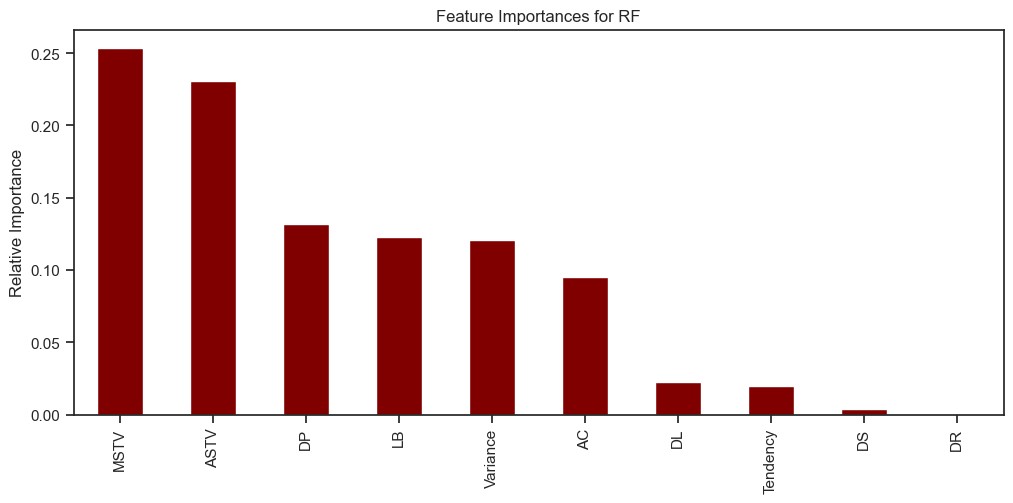

In [154]:
# Random Forest Classifier
start_time = time.time()
print(f"Baseline Random Forest Classifier\n{(lambda x: '.'*40)(None)}")
params = model_hyperparams['rf']
rf_clf = RandomForestClassifier(**params)
rf_clf.fit(X_train, y_train)

# Visualize feature importances to better understand each feature's weight
feature_imp = pd.Series(rf_clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
fig = plt.figure(figsize=(12,5))
ax = feature_imp.plot(kind='bar',color="maroon")
ax.set_title('Feature Importances for RF')
ax.set(ylabel='Relative Importance')
print()

# Cross-validation score 
scores = cross_val_score(rf_clf, X_train, y_train, cv=4, scoring='accuracy')
print("Cross-validation scores:", scores)
print()
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)
train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
measure_error(y_test, y_test_pred, 'test')],axis=1)
print("Acc, Precision, F1 Score and Recall table")
print(train_test_full_error)
print()

# Perform gridSearch
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 400, 500, 600, 700],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

# Instantiate RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform Grid Search CV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=4, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Performing GridSearch to find best params...")
print()
print("Found the best parameters!")
print()
print("Best Parameters:", best_params)
print("Best Cross-validation Accuracy:", best_score)

# Create a new RandomForestClassifier with the best parameters
clf = RandomForestClassifier(random_state=42, **best_params)
clf.fit(X_train, y_train)
print()
print("RF clf fitted with best params")
model_accuracy(clf, X_train, y_train)
print()
elapsed_time = timer()

Optimised RF clf fitted with best params
........................................

Acc, Precision, F1 Score and Recall table
              train      test
accuracy   0.960811  0.910377
precision  0.960231  0.907209
recall     0.960811  0.910377
f1         0.960116  0.907343
Classification Report of model:               precision    recall  f1-score   support

         1.0       0.93      0.97      0.95       165
         2.0       0.76      0.66      0.70        29
         3.0       0.93      0.78      0.85        18

    accuracy                           0.91       212
   macro avg       0.87      0.80      0.83       212
weighted avg       0.91      0.91      0.91       212

Confusion matrix:
 [[160   4   1]
 [ 10  19   0]
 [  2   2  14]]


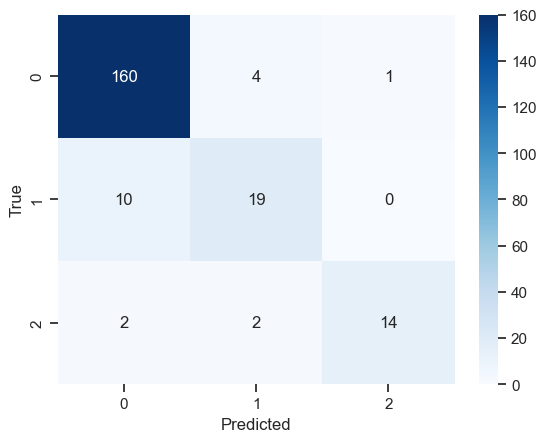



Validation Accuracy: 0.9198113207547169



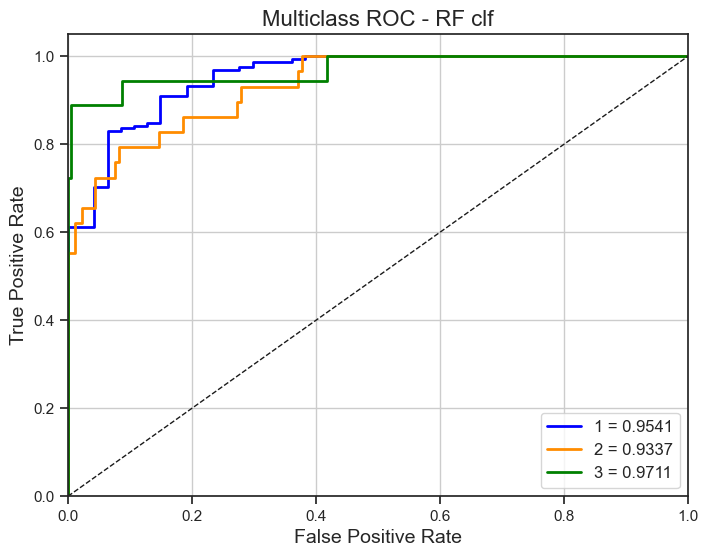

RF clf AUC Summary
........................................
Micro-average AUC = 0.9794
Macro-average AUC = 0.9554

Top 5 feature importances
ASTV        0.241670
MSTV        0.231800
LB          0.138616
DP          0.121801
Variance    0.119532
dtype: float64


Elapsed 1.95 seconds


In [155]:
start_time = time.time()
print(f"Optimised RF clf fitted with best params\n{(lambda x: '.'*40)(None)}")
print("\nAcc, Precision, F1 Score and Recall table")
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
measure_error(y_test, y_test_pred, 'test')],axis=1)
print(train_test_full_error)

evaluate_model(clf, X_test, y_test)
get_validation_accuracy(clf, X_val, y_val)

plot_multiclass_roc(
    clf=clf,
    X_test=X_test,
    y_test=y_test,
    class_labels=[1,2,3],
    model_name="RF clf"
)
print()
top5_feature_importances(clf, feature_cols)
elapsed_time = timer()

>>> Optimize by using SMOTEomek for oversampling and undersampling strategies
Original training set shape: (1480, 10), (1480,)
Resampled training set shape: (3433, 10), (3433,)

Optimize RF CLF with SMOTEomek

Training RF CLF..
Confusion matrix:
 [[1130   18    5]
 [  11  191    3]
 [   1    5  116]]


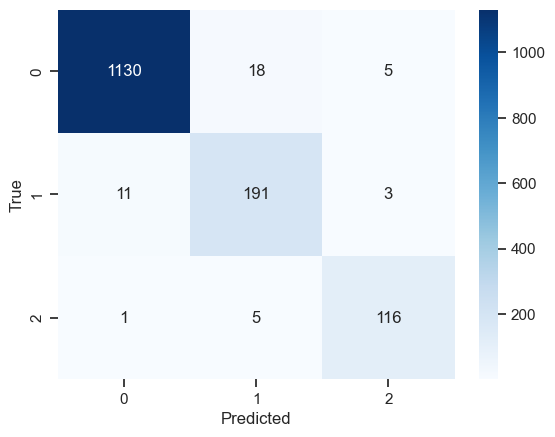

None

Classification Report
              precision    recall  f1-score   support

         1.0       0.99      0.98      0.98      1153
         2.0       0.89      0.93      0.91       205
         3.0       0.94      0.95      0.94       122

    accuracy                           0.97      1480
   macro avg       0.94      0.95      0.95      1480
weighted avg       0.97      0.97      0.97      1480


AUC score = 0.96658
Cross-validated ROC AUC: 0.9727549629701139
              train      test
accuracy   0.970946  0.919811
precision  0.971609  0.917918
recall     0.970946  0.919811
f1         0.971196  0.918614

F1 (macro): 0.8540326040326041
F1 (weighted): 0.9186138631893348
F1 (micro): 0.9198113207547169

Detailed Report:
               precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       165
         2.0       0.78      0.72      0.75        29
         3.0       0.88      0.83      0.86        18

    accuracy                           0.9

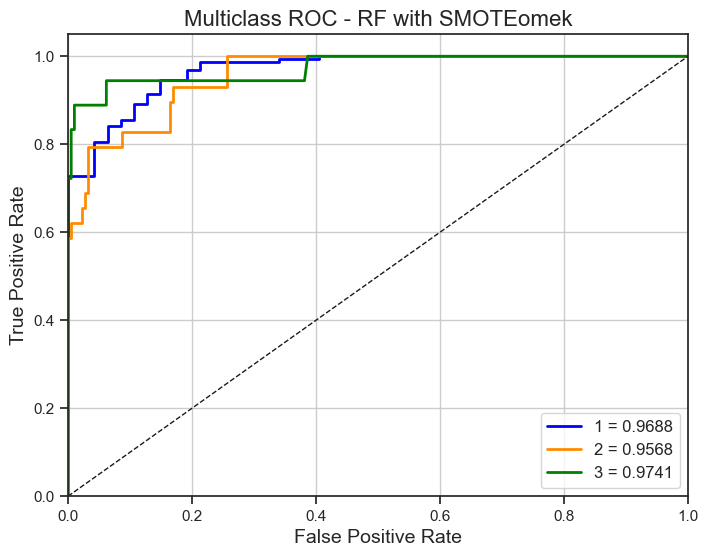

RF with SMOTEomek AUC Summary
........................................
Micro-average AUC = 0.9852
Macro-average AUC = 0.9681

Elapsed 16.51 seconds


In [343]:
start_time = time.time()
print(">>> Optimize by using SMOTEomek for oversampling and undersampling strategies")

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled training set shape: {X_train_smt.shape}, {y_train_smt.shape}")

print()
print("Optimize RF CLF with SMOTEomek")
print()
# with SMOTEomek
print("Training RF CLF..")
# Fit with optimised RF params
clf_smt = clf
clf_smt.fit(X_train_smt, y_train_smt)
evaluation_metrics(clf_smt, X_train, y_train, X_test, y_test)
print()
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("F1 (micro):", f1_score(y_test, y_pred, average='micro'))
print("\nDetailed Report:\n", classification_report(y_test, y_pred))
print()
top5_feature_importances(clf_smt, X_train.columns.tolist())
plot_multiclass_roc(
    clf=clf_smt,
    X_test=X_test,
    y_test=y_test,
    class_labels=[1,2,3],
    model_name="RF with SMOTEomek"
)
elapsed_time = timer()

### XGBoost

XGBoost Classifier
........................................


Confusion matrix:
 [[1146    6    1]
 [   6  197    2]
 [   0    4  118]]


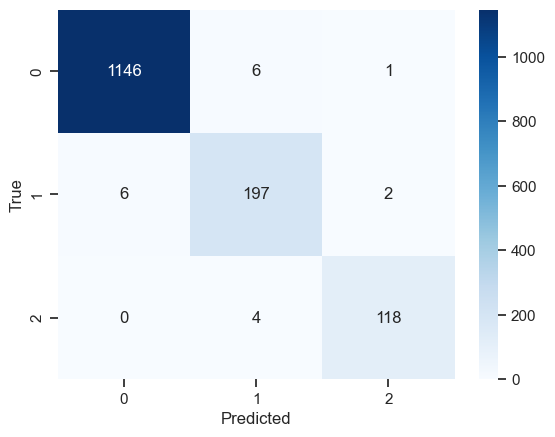

None

Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1153
         1.0       0.95      0.96      0.96       205
         2.0       0.98      0.97      0.97       122

    accuracy                           0.99      1480
   macro avg       0.97      0.97      0.97      1480
weighted avg       0.99      0.99      0.99      1480


AUC score = 0.93549
Cross-validated ROC AUC: 0.9658508258545855
              train      test
accuracy   0.987162  0.915094
precision  0.987207  0.910970
recall     0.987162  0.915094
f1         0.987180  0.911078

F1 (macro): 0.007978723404255319
F1 (weighted): 0.024839421918908068
F1 (micro): 0.014150943396226415

Detailed Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.13      0.02      0.03       165
         2.0       0.00      0.00      0.00        29
         3.0       0.00      0.00    

C:\Users\ZzSle\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ZzSle\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ZzSle\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ZzSle\anaconda3\lib\site-packages\sklearn\metrics\_cla

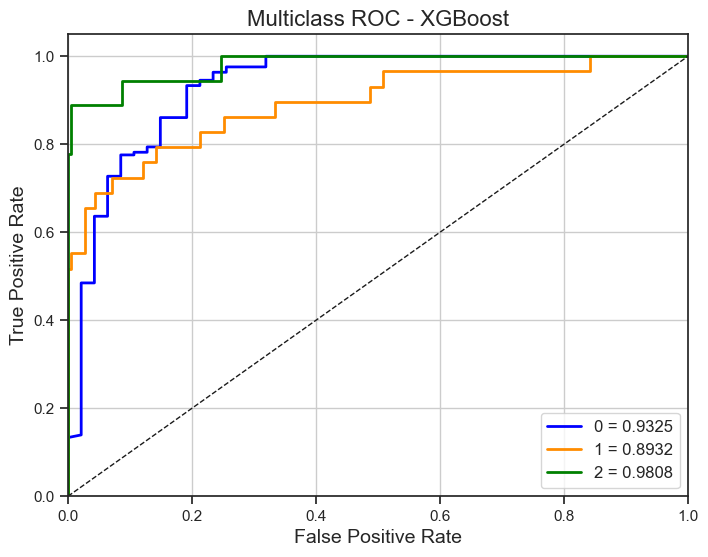

XGBoost AUC Summary
........................................
Micro-average AUC = 0.9747
Macro-average AUC = 0.9409

Elapsed 6.09 seconds


In [347]:
# Init xgb
# Convert X_train.columns to list (required for feature_names parameter in xgb.DMatrix)
start_time = time.time()
feature_names = X_train.columns.tolist()

y_train_adj = y_train - 1
y_test_adj  = y_test  - 1
y_val_adj   = y_val   - 1

# Create DMatrix
dtrain = xgb.DMatrix(data=X_train, label=y_train_adj, feature_names=feature_names)
print(f"XGBoost Classifier\n{(lambda x: '.'*40)(None)}")
params = model_hyperparams['xgb']
xgb_clf = xgb.XGBClassifier(**params)
xgb_clf.fit(X_train, y_train_adj)
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)
print()
# Predict and evaluate
print()
evaluation_metrics(xgb_clf, X_train, y_train_adj, X_test, y_test_adj)
print()
print("F1 (macro):", f1_score(y_test, y_test_pred, average='macro'))
print("F1 (weighted):", f1_score(y_test, y_test_pred, average='weighted'))
print("F1 (micro):", f1_score(y_test, y_test_pred, average='micro'))
print("\nDetailed Report:\n", classification_report(y_test, y_test_pred))
print()
top5_feature_importances(xgb_clf, X_train.columns.tolist())
plot_multiclass_roc(
    clf=xgb_clf,
    X_test=X_test,
    y_test=y_test_adj,
    class_labels=[0, 1, 2],
    model_name="XGBoost"
)
elapsed_time = timer()

Ensemble Accuracy: 0.9150943396226415
Ensemble Macro AUC: 0.9497872013572576

Model 2 is better.


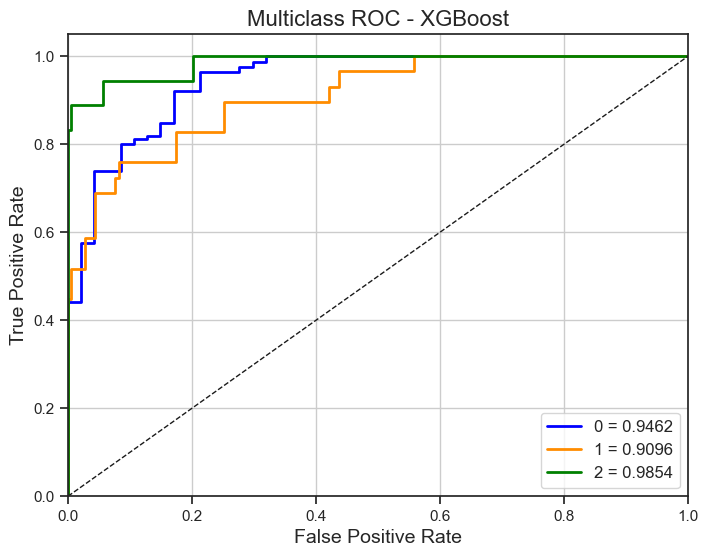

XGBoost AUC Summary
........................................
Micro-average AUC = 0.9781
Macro-average AUC = 0.9510

Top 5 feature importances
DS      0.249669
DP      0.225899
AC      0.161488
MSTV    0.082462
ASTV    0.066888
dtype: float32


Elapsed 2.93 seconds


In [157]:
# Define individual XGB models
start_time = time.time()
model1 = xgb.XGBClassifier(n_estimators=200, max_depth=50,  subsample = 0.2, colsample_bytree = 0.5, random_state=42)
model2 = xgb.XGBClassifier(n_estimators=300, max_depth=60,  subsample = 0.5, colsample_bytree = 0.3, random_state=42)
model3 = xgb.XGBClassifier(n_estimators=300, max_depth=40,  subsample = 0.2, colsample_bytree = 0.5, random_state=42)

ensemble_clf.fit(X_train, y_train_adj)

# Accuracy
accuracy = ensemble_clf.score(X_test, y_test_adj)
print("Ensemble Accuracy:", accuracy)

# Predict probabilities
y_probs = ensemble_clf.predict_proba(X_test)

# Compute multi-class ROC AUC
auc_score = roc_auc_score(y_test_adj, y_probs, multi_class='ovr', average='macro')
print("Ensemble Macro AUC:", auc_score)

model1.fit(X_train, y_train_adj)
model2.fit(X_train, y_train_adj)
y_probs_model1 = model1.predict_proba(X_test)
y_probs_model2 = model2.predict_proba(X_test)

auc_score_model1 = roc_auc_score(y_test_adj, y_probs_model1, multi_class='ovr', average='macro')
auc_score_model2 = roc_auc_score(y_test_adj, y_probs_model2, multi_class='ovr', average='macro')

if auc_score_model1 > auc_score_model2:
    print("\nModel 1 is better.")
    plot_multiclass_roc(
        clf=model1,
        X_test=X_test,
        y_test=y_test_adj,
        class_labels=[0, 1, 2],
        model_name="XGBoost"
    )
    print()
    top5_feature_importances(model1, feature_cols)
elif auc_score_model2 > auc_score_model1:
    print("\nModel 2 is better.")
    plot_multiclass_roc(
        clf=model2,
        X_test=X_test,
        y_test=y_test_adj,
        class_labels=[0, 1, 2],
        model_name="XGBoost"
    )
    print()
    top5_feature_importances(model2, feature_cols)
else:
    print("\nBoth models have the same AUC score.")
    plot_multiclass_roc(
        clf=ensemble_clf,
        X_test=X_test,
        y_test=y_test_adj,
        class_labels=[0, 1, 2],
        model_name="XGBoost"
    )
    print()
    top5_feature_importances(ensemble_clf, feature_cols)
elapsed_time = timer()

>>> Optimize by using SMOTEomek for oversampling and undersampling strategies
Original training set shape: (1480, 10), (1480,)
Resampled training set shape: (3433, 10), (3433,)

Optimize xgb CLF with SMOTEomek

Training xgb CLF..
Confusion matrix:
 [[1147    6    0]
 [   4  200    1]
 [   0    2  120]]


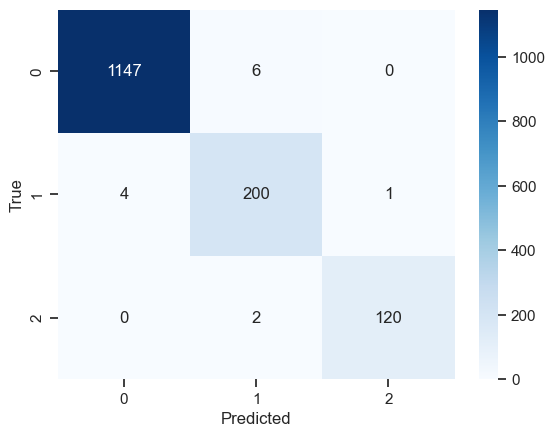

None

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1153
         1.0       0.96      0.98      0.97       205
         2.0       0.99      0.98      0.99       122

    accuracy                           0.99      1480
   macro avg       0.98      0.98      0.98      1480
weighted avg       0.99      0.99      0.99      1480


AUC score = 0.95228
Cross-validated ROC AUC: 0.968180539000431
              train      test
accuracy   0.991216  0.905660
precision  0.991284  0.901349
recall     0.991216  0.905660
f1         0.991241  0.902777

F1 (macro): 0.8540326040326041
F1 (weighted): 0.9186138631893348
F1 (micro): 0.9198113207547169

Detailed Report:
               precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       165
         2.0       0.78      0.72      0.75        29
         3.0       0.88      0.83      0.86        18

    accuracy                           0.92

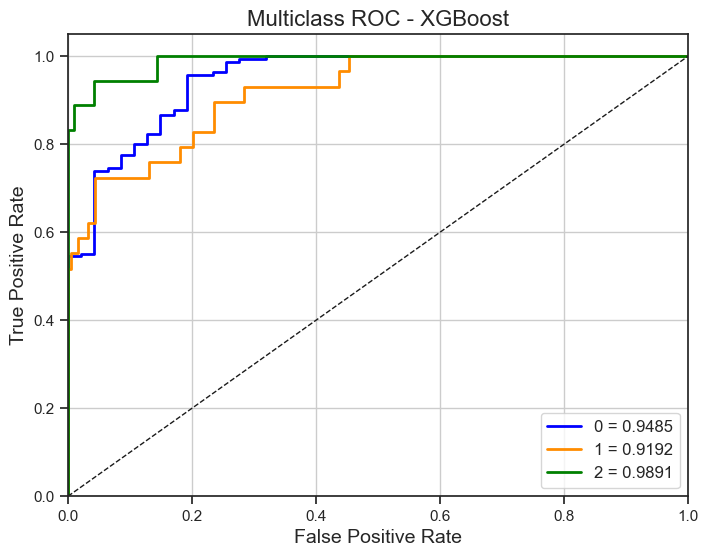

XGBoost AUC Summary
........................................
Micro-average AUC = 0.9808
Macro-average AUC = 0.9544

Elapsed 7.48 seconds


In [346]:
start_time = time.time()
print(">>> Optimize by using SMOTEomek for oversampling and undersampling strategies")
y_train_adj = y_train - 1
y_test_adj  = y_test  - 1
y_val_adj   = y_val   - 1

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train_adj)

print(f"Original training set shape: {X_train.shape}, {y_train_adj.shape}")
print(f"Resampled training set shape: {X_train_smt.shape}, {y_train_smt.shape}")

print()
print("Optimize xgb CLF with SMOTEomek")
print()
# with SMOTEomek
print("Training xgb CLF..")
# Fit with model2 params
xgb_smt = xgb.XGBClassifier(n_estimators=300, max_depth=60,  subsample = 0.5, colsample_bytree = 0.3, random_state=42)
xgb_smt.fit(X_train_smt, y_train_smt)
evaluation_metrics(xgb_smt, X_train, y_train_adj, X_test, y_test_adj)
print()
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("F1 (micro):", f1_score(y_test, y_pred, average='micro'))
print("\nDetailed Report:\n", classification_report(y_test, y_pred))
print()
top5_feature_importances(xgb_smt, X_train.columns.tolist())
plot_multiclass_roc(
    clf=xgb_smt,
    X_test=X_test,
    y_test=y_test_adj,
    class_labels=[0, 1, 2],
    model_name="XGBoost"
)
elapsed_time = timer()

### Predictions on test data

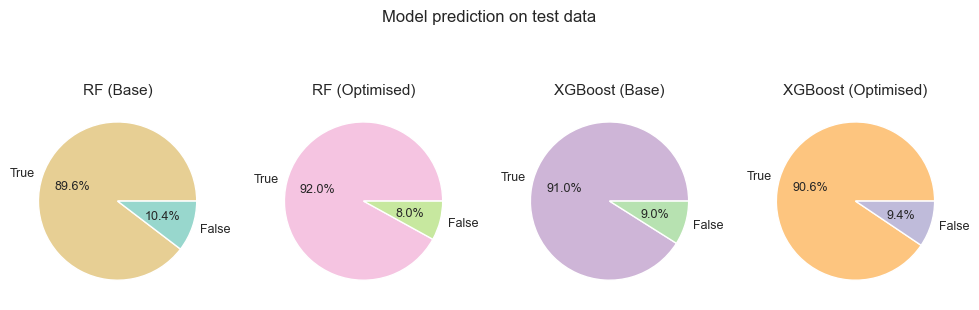

In [272]:
data_list = [
    (tableFormat(base_rf_clf, X_test, y_test, False), "RF (Base)", 'BrBG'),
    (tableFormat(clf_smt, X_test, y_test, False), "RF (Optimised)", 'PiYG'),
    (tableFormat(model2, X_test, y_test, True), "XGBoost (Base)", 'PRGn'),
    (tableFormat(xgb_smt, X_test, y_test, True), "XGBoost (Optimised)", 'PuOr')
]

fig, axs = plt.subplots(1, 4, figsize=(10, 4))

for ax, (df, title, palette_name) in zip(axs, data_list):
    counts = df['Correct'].value_counts()
    palette = sns.color_palette(palette_name, n_colors=len(counts))
    ax.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=palette,
        textprops={'fontsize': 9}
    )
    ax.set_title(title, fontsize=11)
plt.tight_layout()
fig.suptitle("Model prediction on test data", fontsize=12)
plt.show()

Distribution of classes =
1.0    165
2.0     29
3.0     18
Name: Actual_Class, dtype: int64

RF CLF (BASE)
........................................


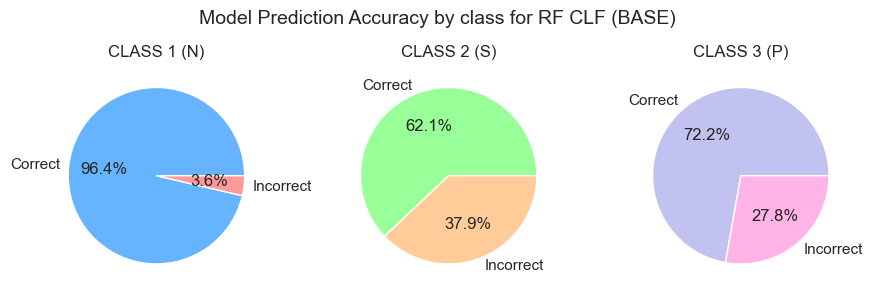

RF CLF (OPTIMISED)
........................................


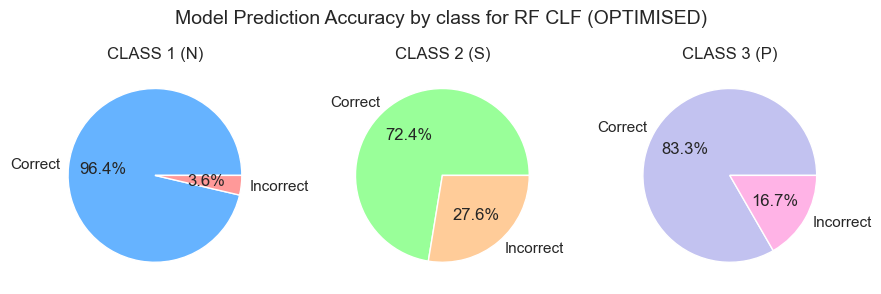

XGB CLF (BASE)
........................................


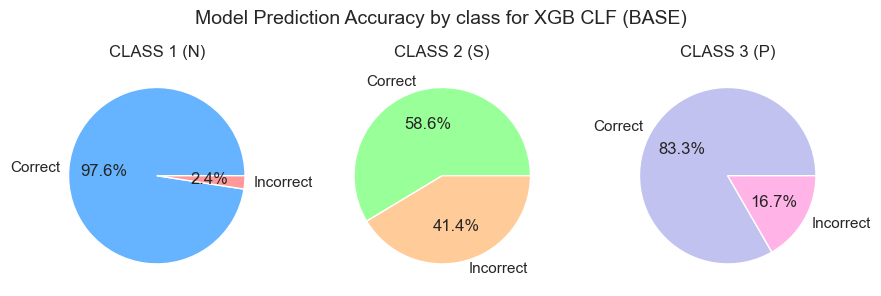

XGB CLF (OPTIMISED)
........................................


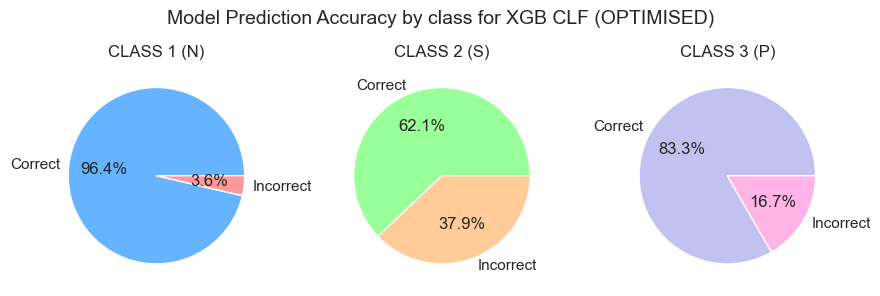

In [329]:
print(f'Distribution of classes =\n{tableFormat(base_rf_clf, X_test, y_test , False)["Actual_Class"].value_counts()}\n')
plotAcc("RF CLF (BASE)",base_rf_clf, X_test, y_test , b_=False)
plotAcc("RF CLF (OPTIMISED)",clf_smt, X_test, y_test , b_=False)
plotAcc("XGB CLF (BASE)",model2, X_test, y_test, b_=True)
plotAcc("XGB CLF (OPTIMISED)",xgb_smt, X_test, y_test , b_=True)

In [226]:
# Random Forest
rfclf_pred = tableFormat(base_rf_clf, X_test.head(20), 
                         y_test[:20], False)
rfclf_pred

,Actual_Class,Predicted_Class,Prob_Class_1 (%),Prob_Class_2 (%),Prob_Class_3 (%),Correct
0,1.0,1.0,91.114883,4.335224,4.549893,True
1,1.0,1.0,99.555931,0.400565,0.043504,True
2,2.0,1.0,82.151352,17.779434,0.069214,False
3,1.0,1.0,98.100355,1.439104,0.460541,True
4,1.0,1.0,81.504658,18.451646,0.043696,True
5,1.0,1.0,64.728789,35.257698,0.013514,True
6,1.0,1.0,97.043362,2.801414,0.155224,True
7,1.0,1.0,98.131012,0.951380,0.917608,True
8,1.0,1.0,62.991921,33.918589,3.089490,True
9,3.0,2.0,9.915815,55.350138,34.734048,False


In [274]:
# Optimised Random Forest
rfclf_pred = tableFormat(clf_smt, X_test.head(20), 
                         y_test[:20], False)
rfclf_pred

,Actual_Class,Predicted_Class,Prob_Class_1 (%),Prob_Class_2 (%),Prob_Class_3 (%),Correct
0,1.0,1.0,76.463966,19.616673,3.919360,True
1,1.0,1.0,99.916667,0.083333,0.000000,True
2,2.0,1.0,71.485343,28.514657,0.000000,False
3,1.0,1.0,98.579183,1.420817,0.000000,True
4,1.0,1.0,56.707695,43.292305,0.000000,True
5,1.0,2.0,35.721329,64.278671,0.000000,False
6,1.0,1.0,97.377399,2.479744,0.142857,True
7,1.0,1.0,97.928344,1.566536,0.505120,True
8,1.0,2.0,40.449258,56.754937,2.795806,False
9,3.0,2.0,0.487393,59.753017,39.759590,False


In [275]:
# Optimised XGBoost
model2_pred = tableFormat(model2,  X_test.head(20), 
                         y_test[:20], True)
model2_pred

,Actual_Class,Predicted_Class,Prob_Class_1 (%),Prob_Class_2 (%),Prob_Class_3 (%),Correct
0,1.0,1,98.737434,1.251165,1.140377e-02,True
1,1.0,1,99.999825,0.000155,2.203141e-05,True
2,2.0,1,99.700127,0.298530,1.342365e-03,False
3,1.0,1,99.999146,0.000820,3.417746e-05,True
4,1.0,1,95.837196,4.133314,2.948676e-02,True
5,1.0,2,30.497969,69.500893,1.137095e-03,False
6,1.0,1,99.875748,0.121788,2.465778e-03,True
7,1.0,1,99.951424,0.046517,2.056513e-03,True
8,1.0,2,29.466143,70.516426,1.742710e-02,False
9,3.0,3,0.039527,49.473373,5.048709e+01,True


In [229]:
# SMOTEomek + Optimised XGBoost
xgb_pred = tableFormat(xgb_smt, X_test.head(20), 
                         y_test[:20], True)
xgb_pred

,Actual_Class,Predicted_Class,Prob_Class_1 (%),Prob_Class_2 (%),Prob_Class_3 (%),Correct
0,1.0,1,99.587509,0.386520,2.597358e-02,True
1,1.0,1,99.999550,0.000304,1.434081e-04,True
2,2.0,1,99.216896,0.782498,6.058032e-04,False
3,1.0,1,99.997841,0.002155,7.135030e-06,True
4,1.0,1,94.091881,5.900061,8.058257e-03,True
5,1.0,1,51.917435,48.081261,1.303370e-03,True
6,1.0,1,99.221413,0.776876,1.709472e-03,True
7,1.0,1,99.855835,0.142760,1.405058e-03,True
8,1.0,2,14.694834,85.298920,6.249249e-03,False
9,3.0,2,0.113155,65.686424,3.420042e+01,False


### Predictions on validation data

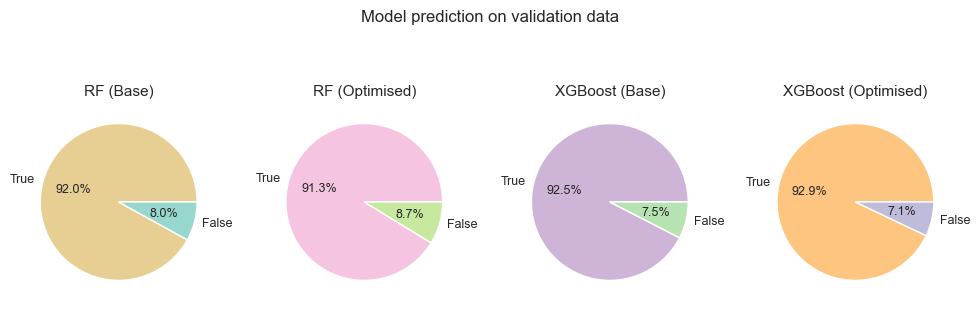

In [273]:
data_list = [
    (tableFormat(base_rf_clf, X_val, y_val, False), "RF (Base)", 'BrBG'),
    (tableFormat(clf_smt, X_val, y_val, False), "RF (Optimised)", 'PiYG'),
    (tableFormat(model2, X_val, y_val, True), "XGBoost (Base)", 'PRGn'),
    (tableFormat(xgb_smt, X_val, y_val, True), "XGBoost (Optimised)", 'PuOr')
]

fig, axs = plt.subplots(1, 4, figsize=(10, 4))

for ax, (df, title, palette_name) in zip(axs, data_list):
    counts = df['Correct'].value_counts()
    palette = sns.color_palette(palette_name, n_colors=len(counts))
    ax.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=palette,
        textprops={'fontsize': 9}
    )
    ax.set_title(title, fontsize=11)
plt.tight_layout()
fig.suptitle("Model prediction on validation data", fontsize=12)
plt.show()

Distribution of classes =
1.0    330
2.0     59
3.0     35
Name: Actual_Class, dtype: int64

RF CLF (BASE)
........................................


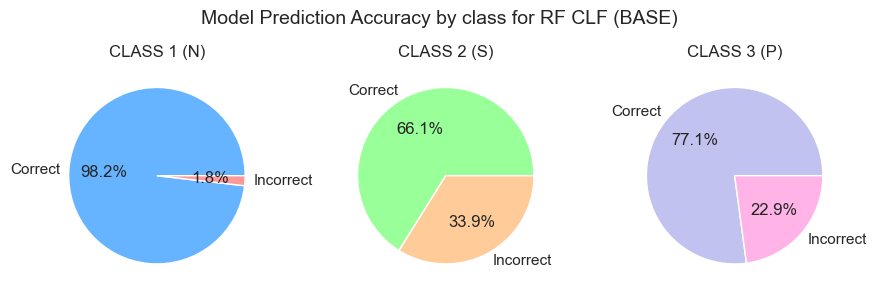

RF CLF (OPTIMISED)
........................................


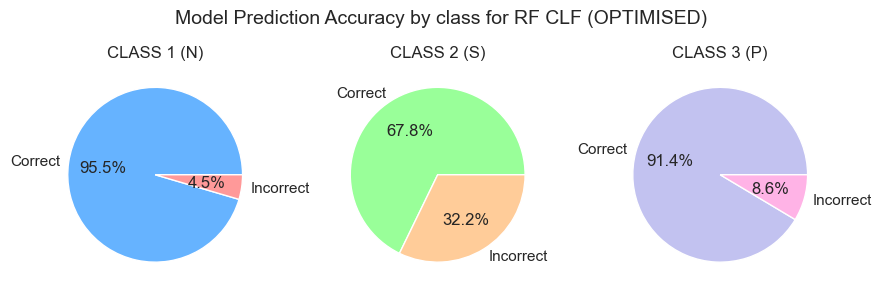

XGB CLF (BASE)
........................................


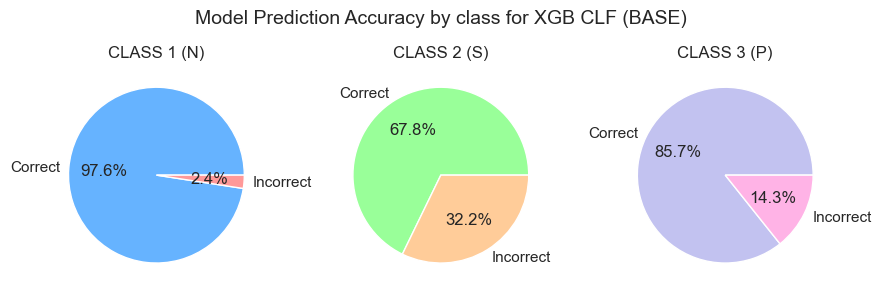

XGB CLF (OPTIMISED)
........................................


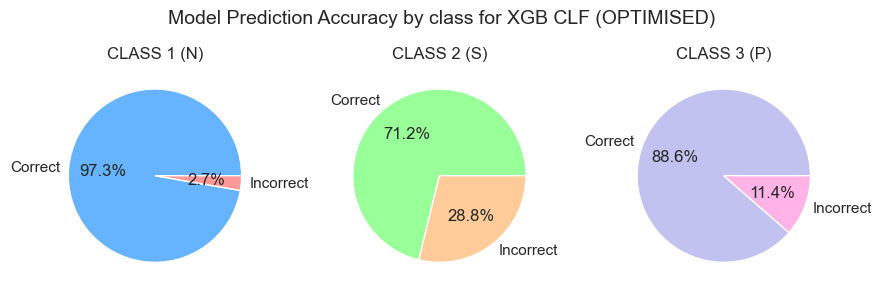

In [330]:
print(f'Distribution of classes =\n{tableFormat(base_rf_clf, X_val, y_val , False)["Actual_Class"].value_counts()}\n')
plotAcc("RF CLF (BASE)",base_rf_clf, X_val, y_val , b_=False)
plotAcc("RF CLF (OPTIMISED)",clf_smt, X_val, y_val , b_=False)
plotAcc("XGB CLF (BASE)",model2, X_val, y_val , b_=True)
plotAcc("XGB CLF (OPTIMISED)",xgb_smt, X_val, y_val , b_=True)

In [237]:
# Random Forest
rfclf_pred = tableFormat(base_rf_clf, X_val.head(20), 
                         y_val[:20], False)
rfclf_pred

,Actual_Class,Predicted_Class,Prob_Class_1 (%),Prob_Class_2 (%),Prob_Class_3 (%),Correct
0,1.0,1.0,99.675047,0.257836,0.067117,True
1,1.0,1.0,95.173467,1.678731,3.147802,True
2,1.0,1.0,98.117833,1.691542,0.190625,True
3,1.0,1.0,99.400129,0.557573,0.042298,True
4,1.0,1.0,88.860450,3.828384,7.311166,True
5,2.0,2.0,4.515501,74.694247,20.790252,True
6,1.0,1.0,92.857240,5.735812,1.406948,True
7,1.0,1.0,83.042879,5.278874,11.678246,True
8,3.0,3.0,5.451127,3.132464,91.416409,True
9,1.0,1.0,90.999296,9.000704,0.000000,True


In [276]:
# Optimised Random Forest
rfclf_pred = tableFormat(clf_smt, X_val.head(20), 
                         y_val[:20], False)
rfclf_pred

,Actual_Class,Predicted_Class,Prob_Class_1 (%),Prob_Class_2 (%),Prob_Class_3 (%),Correct
0,1.0,1.0,99.413492,0.553175,0.033333,True
1,1.0,1.0,94.341974,1.808325,3.849701,True
2,1.0,1.0,95.069312,4.303704,0.626984,True
3,1.0,1.0,99.742036,0.257964,0.000000,True
4,1.0,1.0,90.068274,5.009456,4.922270,True
5,2.0,2.0,0.886123,80.620415,18.493462,True
6,1.0,1.0,96.547228,2.446916,1.005856,True
7,1.0,1.0,84.088625,4.311762,11.599613,True
8,3.0,3.0,0.138889,0.743630,99.117481,True
9,1.0,1.0,94.199289,5.800711,0.000000,True


In [234]:
# Optimised XGBoost
model2_pred = tableFormat(model2,  X_val.head(20), 
                         y_val[:20], True)
model2_pred

,Actual_Class,Predicted_Class,Prob_Class_1 (%),Prob_Class_2 (%),Prob_Class_3 (%),Correct
0,1.0,1,99.999443,0.000131,4.279084e-04,True
1,1.0,1,99.903122,0.012327,8.455891e-02,True
2,1.0,1,99.992287,0.006411,1.304607e-03,True
3,1.0,1,99.999107,0.000819,7.131029e-05,True
4,1.0,1,99.128197,0.041956,8.298445e-01,True
5,2.0,2,0.007707,99.735512,2.567793e-01,True
6,1.0,1,99.891113,0.103987,4.899659e-03,True
7,1.0,1,98.671257,0.004924,1.323817e+00,True
8,3.0,3,0.169171,0.034201,9.979663e+01,True
9,1.0,1,99.917450,0.082339,1.996790e-04,True


In [235]:
# SMOTEomek + Optimised XGBoost
xgb_pred = tableFormat(xgb_smt, X_val.head(20), 
                         y_val[:20], True)
xgb_pred

,Actual_Class,Predicted_Class,Prob_Class_1 (%),Prob_Class_2 (%),Prob_Class_3 (%),Correct
0,1.0,1,99.997856,0.001171,9.753892e-04,True
1,1.0,1,99.929688,0.014973,5.532912e-02,True
2,1.0,1,99.993385,0.004193,2.424765e-03,True
3,1.0,1,99.991096,0.008661,2.453121e-04,True
4,1.0,1,98.252655,0.550374,1.196974e+00,True
5,2.0,2,0.001911,99.889687,1.084017e-01,True
6,1.0,1,99.962143,0.033855,4.003409e-03,True
7,1.0,1,99.152359,0.040456,8.071876e-01,True
8,3.0,3,0.111436,0.026114,9.986246e+01,True
9,1.0,1,99.864883,0.134922,1.932459e-04,True


- Validation data shows slightly better performance (92-92.9% accuracy) compared to test data (89.6-91% accuracy), suggesting that the models generalize reasonably well to unseen data